In [1]:
!pip install xgboost
!pip install shap

You should consider upgrading via the 'd:\ml_python\programi\caffe_bar_sales_analysis\env_win\scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'd:\ml_python\programi\caffe_bar_sales_analysis\env_win\scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
import shap
import xgboost
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

from src.data.make_dataset import load_dataset
from src.features.build_features import MetadataTransformer,CalendarTransformer, HolidaysTransformer, fill_time_series
from sklearn.pipeline import Pipeline
from src.evaluation.scoring import wmape, wbias
from src.data.splitting import split_dataset, time_series_cv

In [2]:
## Functions

def bias(actual: pd.Series, forecast: pd.Series):
    return round(((forecast - actual).sum()/len(actual))*100, 2)
    

In [3]:
dataset = load_dataset()
dataset = dataset.set_index('sales_date')

Dataframe shape:  (38338, 10)
Time (s):  0.40999603271484375
2013 done.
Dataframe shape:  (40317, 10)
Time (s):  0.362255334854126
2014 done.
Dataframe shape:  (42351, 10)
Time (s):  0.41300177574157715
2015 done.
Dataframe shape:  (55354, 10)
Time (s):  0.552081823348999
2016 done.
Dataframe shape:  (64267, 10)
Time (s):  0.5316946506500244
2017 done.
Dataframe shape:  (65991, 10)
Time (s):  0.5509686470031738
2018 done.
Dataframe shape:  (72220, 10)
Time (s):  0.7145609855651855
2019 done.
Dataframe shape:  (43087, 10)
Time (s):  0.4409983158111572
2020 done.
             item_name                sales_date  sales_qty  item_price  \
0                Amaro 2013-03-07 00:00:00+00:00          1         9.0   
1                Amaro 2013-04-14 00:00:00+00:00          1         9.0   
2                Amaro 2013-07-23 00:00:00+00:00          1         9.0   
3                Amaro 2013-07-24 00:00:00+00:00          1         9.0   
4                Amaro 2013-08-11 00:00:00+00:00         

# Dataset exploration

In [4]:
dataset_summary = dataset.reset_index().groupby('item_name').agg({'sales_qty': ['sum', 'count'],
                                                   'sales_date': ['min', 'max']}).reset_index()
dataset_summary.columns = ['item_name', 'sales_per_item', 'days_of_sales', 'min_date', 'max_date']
## Calculate sales ratio and cumulative sum of sales
dataset_summary.loc[:, 'total_sales'] = dataset_summary.sales_per_item.sum()
dataset_summary.loc[:, 'sales_ratio'] = dataset_summary['sales_per_item']/dataset_summary['total_sales']
dataset_summary = dataset_summary.sort_values(by='sales_per_item', ascending=False)
dataset_summary.loc[:, 'sales_ratio_cumsum'] = dataset_summary['sales_ratio'].cumsum()

# Dataset preparation


In [6]:
## Filter dataset to include only items with a big share in sales
filtered_dataset = dataset[dataset.item_name.isin(dataset_summary[:40].item_name.tolist())]

## Fill days with no sales ##
dataset_filled = filtered_dataset.groupby('item_name').apply(fill_time_series).reset_index().set_index('sales_date')

## Generate features ##
pipeline = Pipeline(steps=[
                       ('metadata_tf', MetadataTransformer()),
                       ('calendar_tf', CalendarTransformer()),
                       ('holidays_tf', HolidaysTransformer())
                        ])
dataset_w_feats = pipeline.fit_transform(dataset_filled)

## 

# Configuration

In [10]:
VALID_SPLIT_DATE = '2018-01-01'
TEST_SPLIT_DATE = '2019-01-01'
END_DATE = '2019-12-31'
TARGET = 'sales_qty'

# Experiment - xgboost with old features

In [11]:
PREDICTORS = ['item_price', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
       'month_of_year_1', 'month_of_year_2', 'month_of_year_3',
       'month_of_year_4', 'month_of_year_5', 'month_of_year_6',
       'month_of_year_7', 'month_of_year_8', 'month_of_year_9',
       'month_of_year_10', 'month_of_year_11', 'year', 'first_third_of_month',
       'second_third_of_month', 'last_third_of_month', 'closed', 'easter',
       'easter_monday', 'christmas', 'new_years_day', 'new_years_eve']

In [12]:
# Function which plot learning curves for given metric over number of iterations for both training and validation datasets
def plot_learning_curves(evals_result, metric, ax_main):

    total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
    for sample, vals in evals_result.items():
        ax_main.plot(
            range(1, total_iteration_count + 1), 
            vals[metric],
            label=sample
        )

    ax_main.set_xlabel('iteration')
    ax_main.set_ylabel(metric)
    ax_main.legend(loc='best')
    ax_main.set_title(f'{metric} curves')

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.tick_params(axis='y', colors='gray')
    ax.tick_params(axis='x', colors='gray')

    return

In [13]:
dataset_w_feats[dataset_w_feats.index < VALID_SPLIT_DATE].index.unique()

DatetimeIndex(['2016-06-14 00:00:00+00:00', '2016-06-15 00:00:00+00:00',
               '2016-06-16 00:00:00+00:00', '2016-06-17 00:00:00+00:00',
               '2016-06-18 00:00:00+00:00', '2016-06-19 00:00:00+00:00',
               '2016-06-20 00:00:00+00:00', '2016-06-21 00:00:00+00:00',
               '2016-06-22 00:00:00+00:00', '2016-06-23 00:00:00+00:00',
               ...
               '2016-06-04 00:00:00+00:00', '2016-06-05 00:00:00+00:00',
               '2016-06-06 00:00:00+00:00', '2016-06-07 00:00:00+00:00',
               '2016-06-08 00:00:00+00:00', '2016-06-09 00:00:00+00:00',
               '2016-06-10 00:00:00+00:00', '2016-06-11 00:00:00+00:00',
               '2016-06-12 00:00:00+00:00', '2016-06-13 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='sales_date', length=1799, freq=None)

[0]	train-poisson-nloglik:9.89131	valid-poisson-nloglik:14.88469
[1]	train-poisson-nloglik:8.64295	valid-poisson-nloglik:13.11224
[2]	train-poisson-nloglik:7.51736	valid-poisson-nloglik:11.43588
[3]	train-poisson-nloglik:6.58086	valid-poisson-nloglik:10.04202
[4]	train-poisson-nloglik:5.88418	valid-poisson-nloglik:9.04086
[5]	train-poisson-nloglik:5.25087	valid-poisson-nloglik:7.97913
[6]	train-poisson-nloglik:4.88404	valid-poisson-nloglik:7.63527
[7]	train-poisson-nloglik:4.71136	valid-poisson-nloglik:7.15484
[8]	train-poisson-nloglik:4.39399	valid-poisson-nloglik:6.61521
[9]	train-poisson-nloglik:4.20738	valid-poisson-nloglik:6.33938
[10]	train-poisson-nloglik:4.14335	valid-poisson-nloglik:6.31495
[11]	train-poisson-nloglik:4.12559	valid-poisson-nloglik:6.26531
[12]	train-poisson-nloglik:4.11215	valid-poisson-nloglik:6.21881
[13]	train-poisson-nloglik:4.05349	valid-poisson-nloglik:6.08194
[14]	train-poisson-nloglik:4.01801	valid-poisson-nloglik:6.00645
[15]	train-poisson-nloglik:4.01

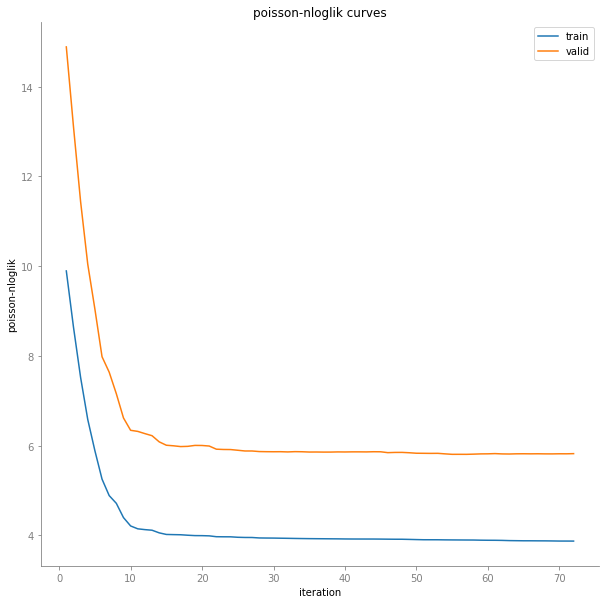

In [14]:
params_default = {
        'eta': 0.5,
        'max_depth': 5,
        'subsample': 0.9,
        'colsample_bytree': 0.7,

        'objective': 'count:poisson', 

        'booster': 'gbtree',
        'tree_method': 'hist',
        # 'max_bin': 30
    }

train_mask = (dataset_w_feats.index < VALID_SPLIT_DATE)
valid_mask = (dataset_w_feats.index >= VALID_SPLIT_DATE) & (dataset_w_feats.index < TEST_SPLIT_DATE)
test_mask = (dataset_w_feats.index >= TEST_SPLIT_DATE) & (dataset_w_feats.index <= END_DATE)

    
evals_result = {}
booster = xgboost.train(
    params=params_default,
    dtrain=xgboost.DMatrix(dataset_w_feats[train_mask][PREDICTORS], dataset_w_feats[train_mask][TARGET]),
    evals=((xgboost.DMatrix(dataset_w_feats[train_mask][PREDICTORS], dataset_w_feats[train_mask][TARGET]), 'train'),
           (xgboost.DMatrix(dataset_w_feats[valid_mask][PREDICTORS], dataset_w_feats[valid_mask][TARGET]), 'valid')),
    evals_result=evals_result,
    num_boost_round=1000,
    early_stopping_rounds = 15,
    verbose_eval = True)

fig, ax = plt.subplots(1, 1, figsize = (10, 10), facecolor='white')
plot_learning_curves(evals_result, 'poisson-nloglik', ax)
plt.show()

In [15]:
dataset_w_feats.loc[:, 'prediction'] = booster.predict(xgboost.DMatrix(dataset_w_feats[PREDICTORS]), iteration_range = (0, booster.best_iteration))


## Feature importances

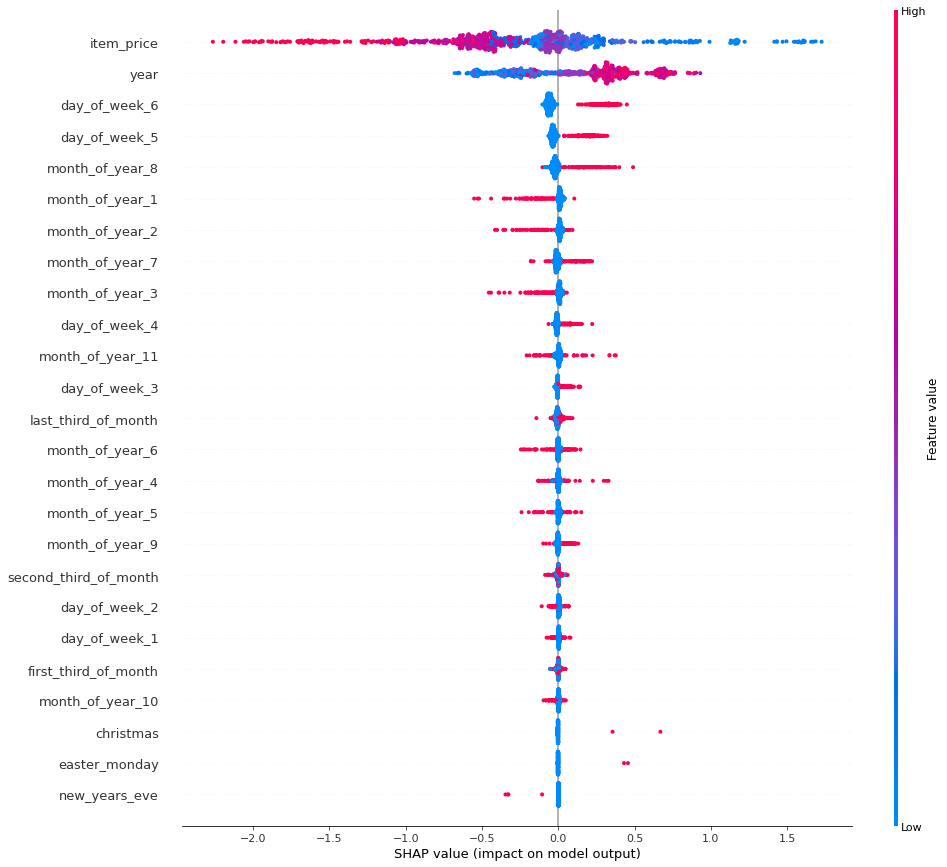

In [16]:
subsample_size = 1000

explainer = shap.TreeExplainer(booster)
predictors = booster.feature_names

df_sample = dataset_w_feats[predictors].sample(subsample_size)

shap_values = explainer(df_sample)

shap.summary_plot(shap_values.values, df_sample, max_display=25, show=True, plot_size=[15,15])
plt.show()

## Errors analysis

In [17]:
## Summary of results
dataset_w_feats.loc[:, 'error_diff'] = dataset_w_feats['prediction'] - dataset_w_feats['sales_qty']
dataset_w_feats.loc[:, 'abs_diff'] = np.abs(dataset_w_feats['prediction'] - dataset_w_feats['sales_qty'])

#wmape_train = dataset_w_feats[train_mask]['abs_diff'].sum()/dataset_w_feats[train_mask]['sales_qty'].sum()
#wmape_test = dataset_w_feats[test_mask]['abs_diff'].sum()/dataset_w_feats[test_mask]['sales_qty'].sum()
wmape_train = wmape(dataset_w_feats[train_mask]['sales_qty'], dataset_w_feats[train_mask]['prediction'])
wmape_test = wmape(dataset_w_feats[test_mask]['sales_qty'], dataset_w_feats[test_mask]['prediction'])

bias_train = wbias(dataset_w_feats[train_mask]['sales_qty'], dataset_w_feats[train_mask]['prediction'])
bias_test = wbias(dataset_w_feats[test_mask]['sales_qty'], dataset_w_feats[test_mask]['prediction'])

print("Train WMAPE:", wmape_train)
print("Test WMAPE:", wmape_test)
print("Train bias:", bias_train)
print("Test bias:", bias_test)

# With 2020
##
#Train WMAPE: 0.8702195722293666
#Test WMAPE: 1.0953026598963962

# With validation dataset
#Train WMAPE: 0.9012110230904323
#Test WMAPE: 1.0365029446076208

# With early stopping 
#Train WMAPE: 0.8941196832457685
#Test WMAPE: 1.0365029446076208
#Train bias: 0.006496775213396749
#Test bias: -0.3893058799106825

# Only 2019 as test set
#Train WMAPE: 89.41
#Test WMAPE: 91.48
#Train wbias: 0.15
#Test wbias: -20.42

Train WMAPE: 89.41
Test WMAPE: 91.48
Train bias: 0.15
Test bias: -20.42


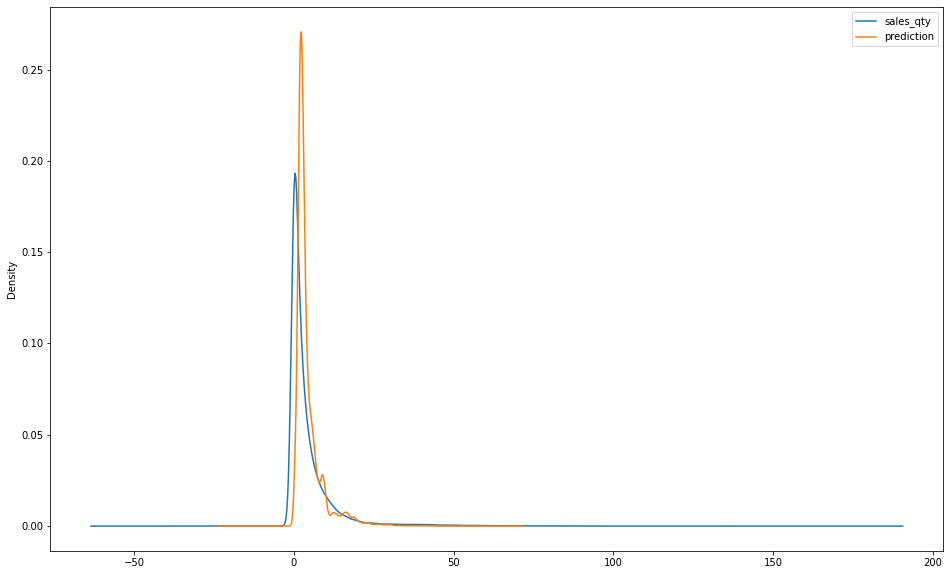

<AxesSubplot:ylabel='Density'>

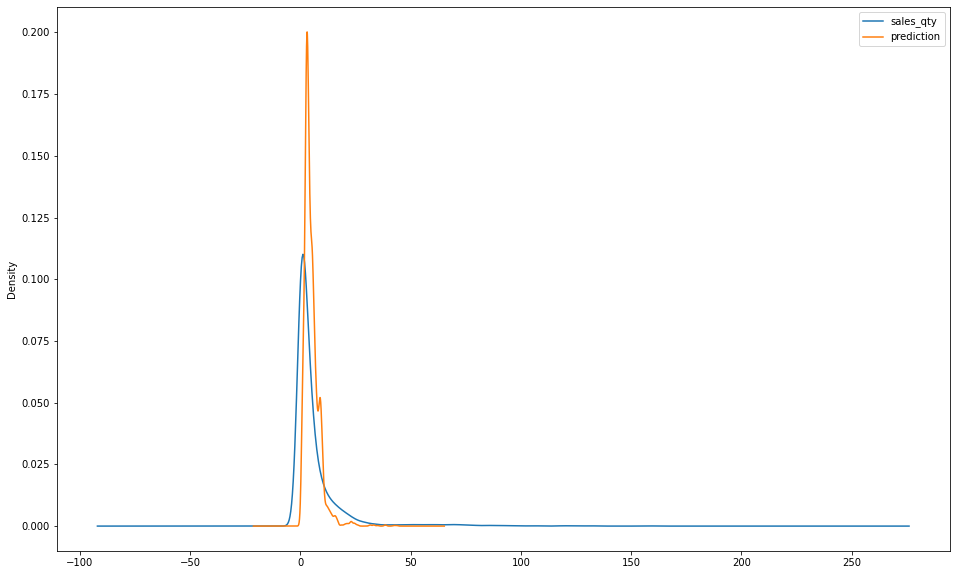

In [18]:
# ## Training set targets
# y_train[y_train>0].plot(kind='hist', bins=100, figsize=(12, 6))
dataset_w_feats[train_mask].plot(y=['sales_qty', 'prediction'], kind='kde', figsize=(16,10))
plt.show()
# ## Test set targets
dataset_w_feats[test_mask].plot(y=['sales_qty', 'prediction'], kind='kde', figsize=(16,10))
# y_pred_test[y_pred_test > 0].plot(kind='hist', bins=100, figsize=(12, 6))

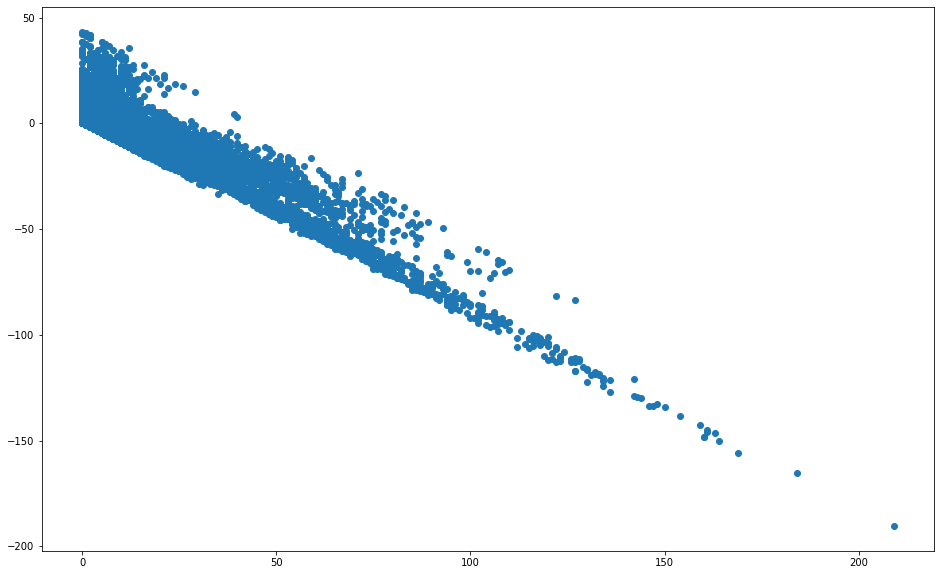

In [19]:
# Overprediction of low quantities and underprediction of high quantities
plt.figure(figsize=(16,10))
plt.scatter(dataset_w_feats.sales_qty, dataset_w_feats.error_diff)

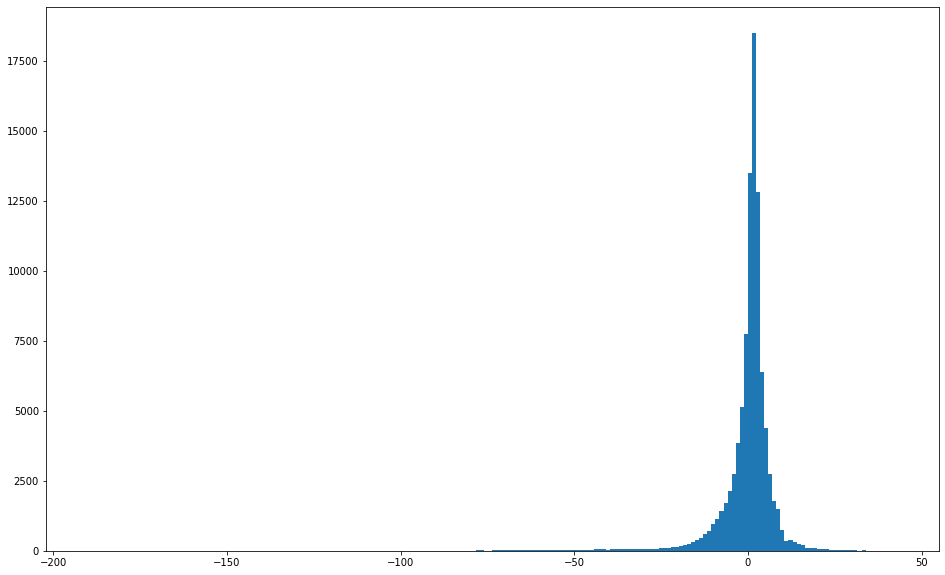

In [20]:
plt.figure(figsize=(16,10))
plt.hist(dataset_w_feats.error_diff, bins=200)
plt.show()

In [21]:
dataset_w_feats.loc[:, 'error_sign'] = (dataset_w_feats['error_diff'] > 0).astype('int')
dataset_w_feats['error_sign'].value_counts()

1    64621
0    32207
Name: error_sign, dtype: int64

<AxesSubplot:xlabel='sales_qty', ylabel='prediction'>

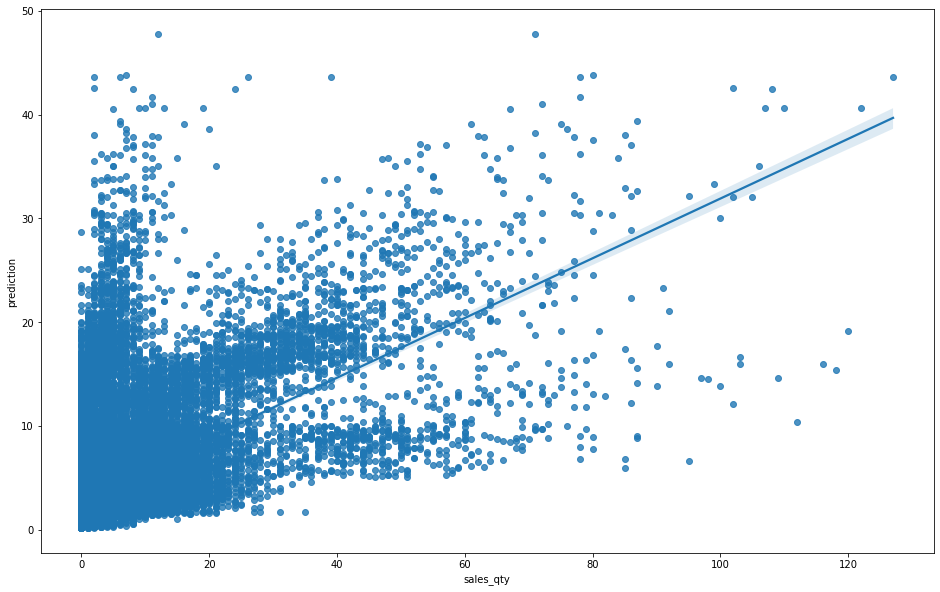

In [22]:
import seaborn as sns
plt.figure(figsize=(16,10))
sns.regplot(data=dataset_w_feats[train_mask], x='sales_qty', y='prediction')

Item:  Beck`s


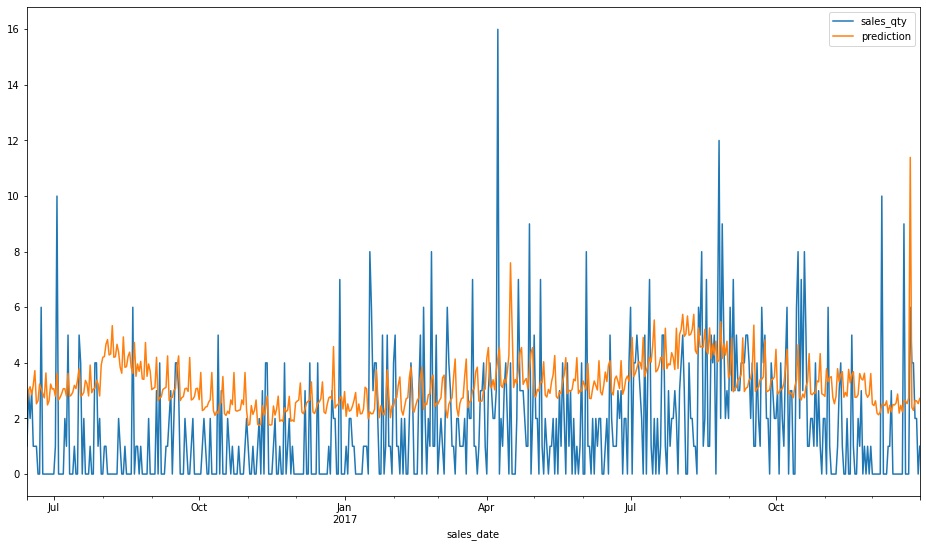

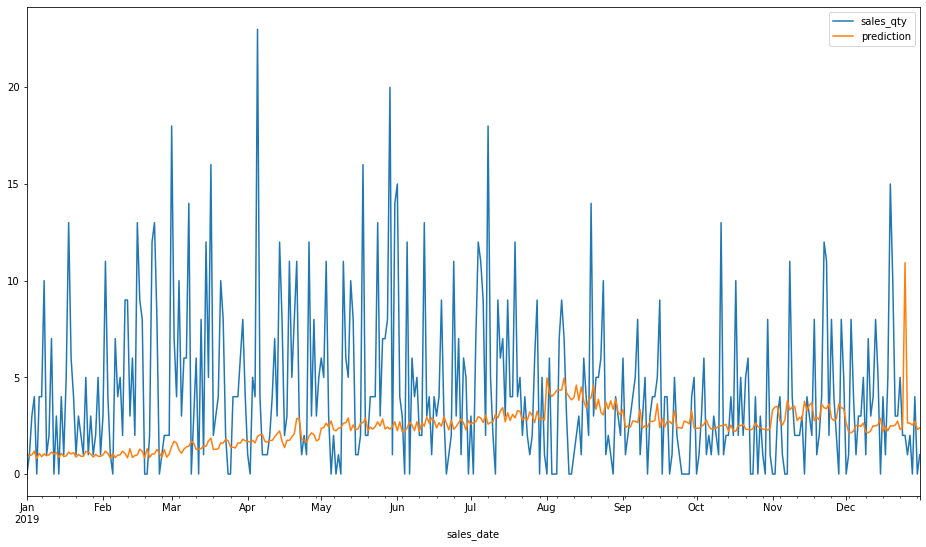

Item:  Coca Cola


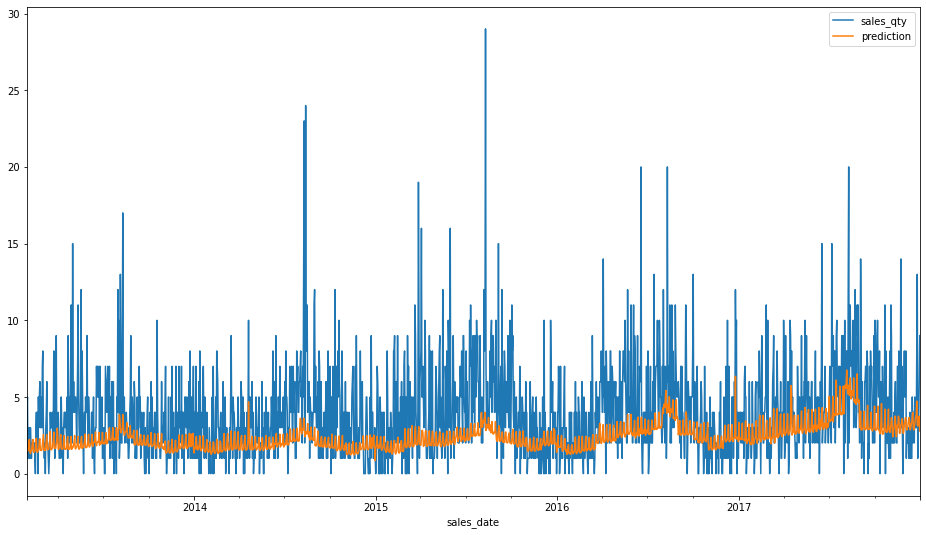

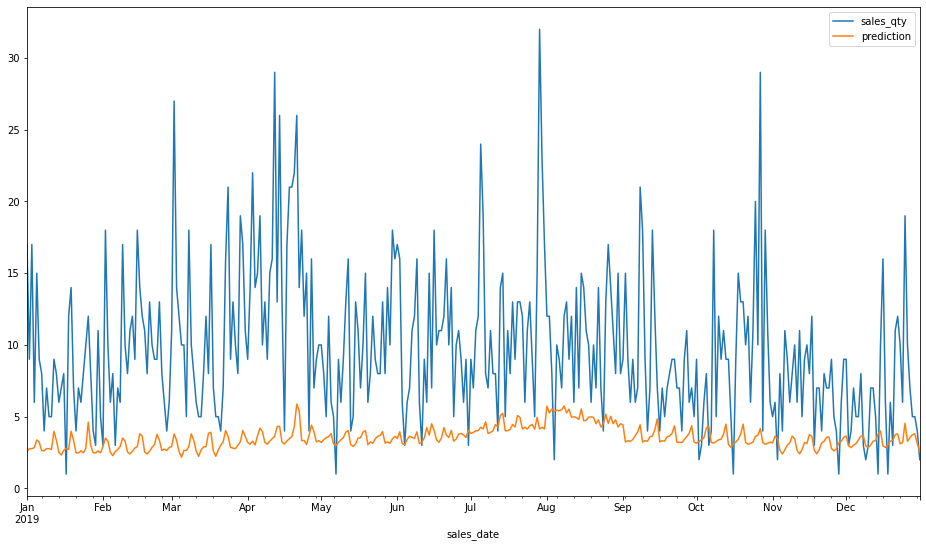

Item:  Caj


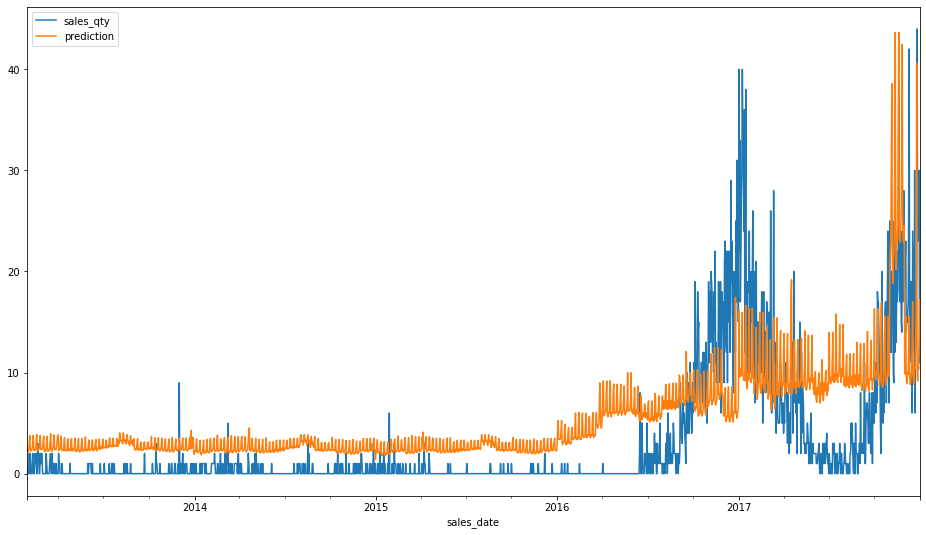

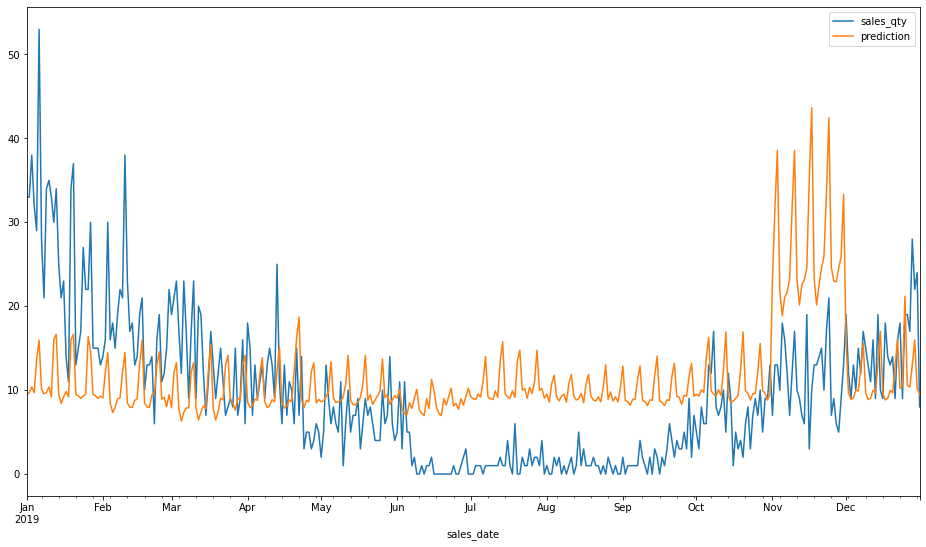

Item:  Cappuccino


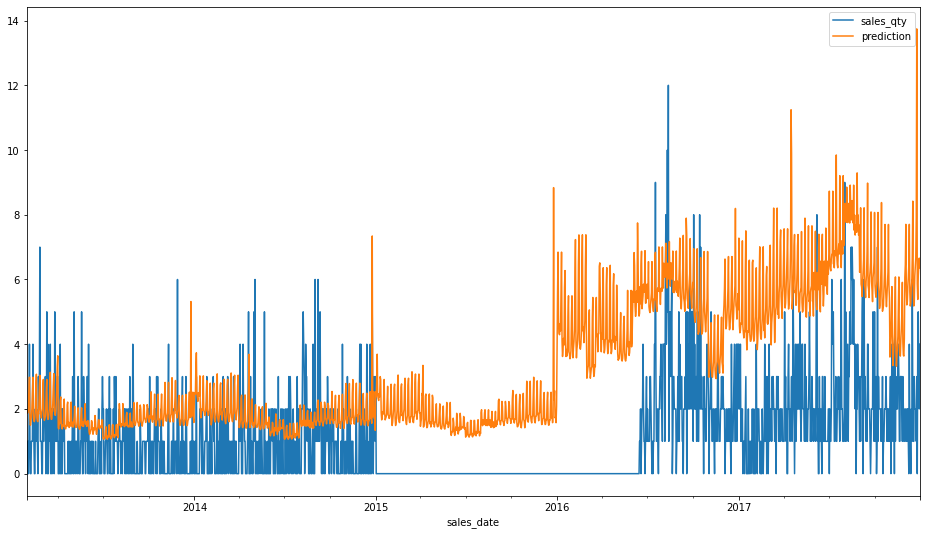

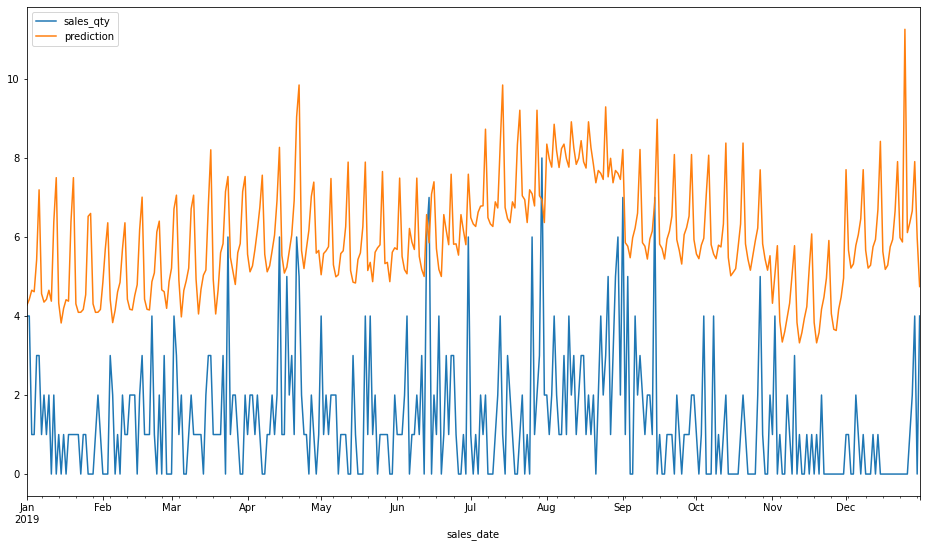

Item:  Orahovac


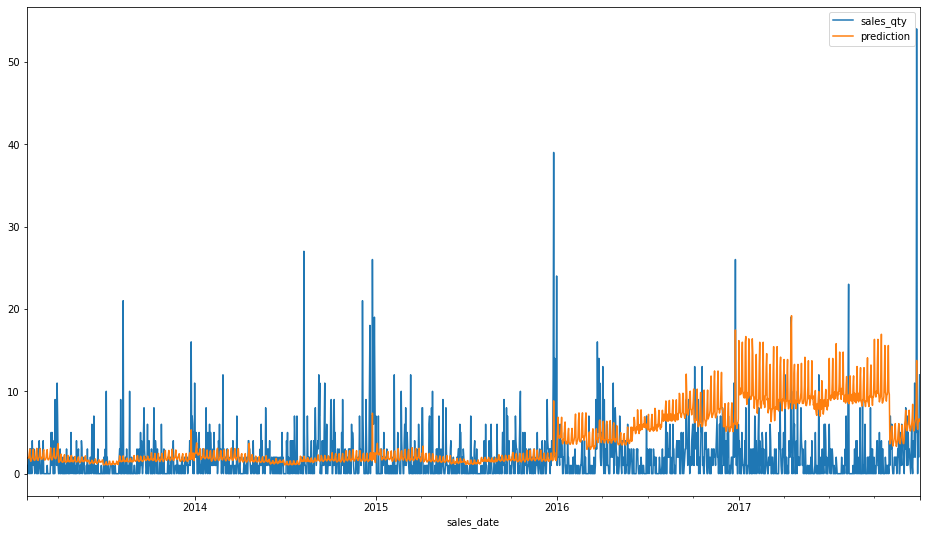

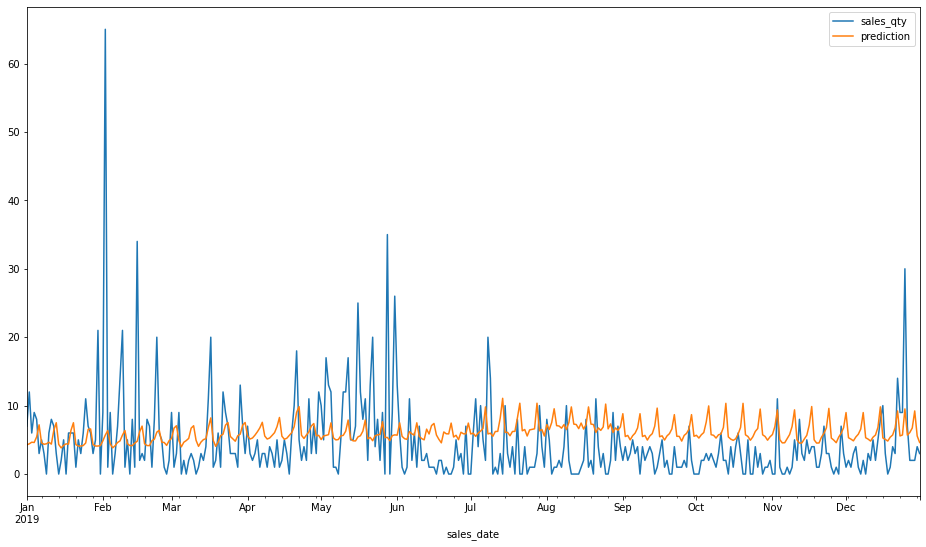

In [23]:
for item in ['Beck`s', 'Coca Cola', 'Caj', 'Cappuccino', 'Orahovac']:
    print("Item: ",item)
    dataset_w_feats[train_mask & (dataset_w_feats.item_name == item)].plot(y=['sales_qty', 'prediction'], figsize=(16,9))
    dataset_w_feats[test_mask & (dataset_w_feats.item_name == item)].plot(y=['sales_qty', 'prediction'], figsize=(16,9))
    plt.show()

# Experiment - xgboost with lagged target direct features

In [21]:
# make weekday uplift
# evaluate without leakage
# check autocorrelation

In [137]:

HOLIDAYS = ['easter', 'easter_monday', 'christmas', 'new_years_day', 'new_years_eve', 'sv_lovre', 'prvi_maj', 'days_to_sv_lovre_7', 'days_since_sv_lovre_7',
       'days_to_new_years_day_7', 'days_since_new_years_day_7', 'days_to_christmas_7', 'days_since_christmas_7']
DAYS_OF_WEEK = [f'day_of_week_{num}' for num in range(1,7)]
PREDICTORS = ['item_price', 'lagged_sales_358d_14d_mean', 'lagged_sales_372d_14d_mean', 'lagged_sales_60d_7d_mean',
       'lagged_sales_35d_7d_mean', 'year', 'avg_weekday_1m', 'lagged_sales_351d_14d_mean', 'lagged_sales_379d_14d_mean',
             'lagged_sales_60d_14d_mean', 'lagged_sales_90d_7d_mean', 'lagged_sales_90d_14d_mean', 'avg_weekday_yearly'
             ] + HOLIDAYS #+ DAYS_OF_WEEK
PREDICTORS

['item_price',
 'lagged_sales_358d_14d_mean',
 'lagged_sales_372d_14d_mean',
 'lagged_sales_60d_7d_mean',
 'lagged_sales_35d_7d_mean',
 'year',
 'avg_weekday_1m',
 'lagged_sales_351d_14d_mean',
 'lagged_sales_379d_14d_mean',
 'lagged_sales_60d_14d_mean',
 'lagged_sales_90d_7d_mean',
 'lagged_sales_90d_14d_mean',
 'avg_weekday_yearly',
 'easter',
 'easter_monday',
 'christmas',
 'new_years_day',
 'new_years_eve',
 'sv_lovre',
 'prvi_maj',
 'days_to_sv_lovre_7',
 'days_since_sv_lovre_7',
 'days_to_new_years_day_7',
 'days_since_new_years_day_7',
 'days_to_christmas_7',
 'days_since_christmas_7']

In [139]:
dataset_w_feats.loc[:, 'lagged_sales_358d_14d_mean'] = dataset_w_feats.groupby(['item_name'])['sales_qty'].shift(365-7).rolling(14, center=True).mean()
dataset_w_feats.loc[:, 'lagged_sales_351d_14d_mean'] = dataset_w_feats.groupby(['item_name'])['sales_qty'].shift(365-14).rolling(14, center=True).mean()
dataset_w_feats.loc[:, 'lagged_sales_372d_14d_mean'] = dataset_w_feats.groupby(['item_name'])['sales_qty'].shift(365+7).rolling(14, center=True).mean()
dataset_w_feats.loc[:, 'lagged_sales_379d_14d_mean'] = dataset_w_feats.groupby(['item_name'])['sales_qty'].shift(365+14).rolling(14, center=True).mean()

dataset_w_feats.loc[:, 'lagged_sales_365d_14d_mean'] = dataset_w_feats.groupby(['item_name'])['sales_qty'].shift(365).rolling(14, center=True).mean()

dataset_w_feats.loc[:, 'lagged_sales_35d_7d_mean'] = dataset_w_feats.groupby(['item_name'])['sales_qty'].shift(28+7).rolling(7, center=True).mean()
#dataset_filled.loc[:, 'lagged_sales_28d'] = dataset_filled.groupby(['item_name'])['sales_qty'].shift(28)
dataset_w_feats.loc[:, 'lagged_sales_60d_7d_mean'] = dataset_w_feats.groupby(['item_name'])['sales_qty'].shift(60).rolling(7, center=True).mean()
dataset_w_feats.loc[:, 'lagged_sales_60d_14d_mean'] = dataset_w_feats.groupby(['item_name'])['sales_qty'].shift(60).rolling(14, center=True).mean()

dataset_w_feats.loc[:, 'lagged_sales_90d_7d_mean'] = dataset_w_feats.groupby(['item_name'])['sales_qty'].shift(90).rolling(7, center=True).mean()
dataset_w_feats.loc[:, 'lagged_sales_90d_14d_mean'] = dataset_w_feats.groupby(['item_name'])['sales_qty'].shift(90).rolling(14, center=True).mean()

In [140]:
dataset_w_feats.loc[:, 'year'] = dataset_w_feats.index.year
dataset_w_feats.loc[:, 'month'] = dataset_w_feats.index.month
dataset_w_feats.loc[:, 'day_of_week'] = dataset_w_feats.index.day_of_week

In [141]:
weekday_averages_df = pd.DataFrame(dataset_w_feats.groupby(['item_name', dataset_w_feats.index.year, dataset_w_feats.index.month, dataset_w_feats.index.dayofweek])['sales_qty'].mean())
weekday_averages_df.index.names = ['item_name', 'year', 'month', 'day_of_week']
# Sales is shifted by one month to ensure no target leakage
weekday_averages_df.loc[:, 'avg_weekday_1m'] = weekday_averages_df['sales_qty'].shift(7)
weekday_averages_df = weekday_averages_df.drop(columns=['sales_qty'])

In [142]:
weekday_averages_year_df = pd.DataFrame(dataset_w_feats.groupby(['item_name', dataset_w_feats.index.year, dataset_w_feats.index.dayofweek])['sales_qty'].mean())
weekday_averages_year_df.index.names = ['item_name', 'year', 'day_of_week']
# Sales is shifted by one month to ensure no target leakage
weekday_averages_year_df.loc[:, 'avg_weekday_yearly'] = weekday_averages_year_df['sales_qty'].shift(7)
weekday_averages_year_df = weekday_averages_year_df.drop(columns=['sales_qty'])

In [143]:
dataset_w_feats = dataset_w_feats.reset_index().merge(weekday_averages_df,how='left', on=['item_name', 'year', 'month', 'day_of_week']).set_index('sales_date')
dataset_w_feats = dataset_w_feats.reset_index().merge(weekday_averages_year_df,how='left', on=['item_name', 'year', 'day_of_week']).set_index('sales_date')

In [144]:
dataset_w_feats.loc[:, 'sv_lovre'] = ((dataset_w_feats.index.month==8) & (dataset_w_feats.index.day==10)).astype('int8')
dataset_w_feats.loc[:, 'prvi_maj'] = ((dataset_w_feats.index.month==5) & (dataset_w_feats.index.day==1)).astype('int8')

In [145]:
def days_next_holiday(date, holidays):
    difference=[]
    for item in holidays:
        difference.append(int(str((item-date).days)))            
    return min(difference, key=abs)

In [146]:
%%time
holidays_df = pd.DataFrame({'dates': dataset_w_feats.index.unique().tolist()})
holidays_df.loc[:, 'sv_lovre'] = ((holidays_df.dates.dt.month==8) & (holidays_df.dates.dt.day==10)).astype('int8')

# holidays_df.loc[:, 'sv_lovre_date'] = holidays_df.dates.dt.year.map({val[0]: val[1] for val in holidays_df[holidays_df['sv_lovre'] == 1][['year', 'dates']].values})
# holidays_df.loc[:, 'days_to_sv_lovre'] = (holidays_df['sv_lovre_date'] - holidays_df['dates']).apply(lambda x: x.days)
holidays_df.loc[:, 'days_sv_lovre'] = holidays_df.dates.apply(lambda x: days_next_holiday(x, holidays_df[holidays_df['sv_lovre'] == 1]['dates']))
holidays_df.loc[:, 'days_to_sv_lovre_7'] = holidays_df[(holidays_df['days_sv_lovre'] > 0) & (holidays_df['days_sv_lovre'] <= 7)]['days_sv_lovre']
holidays_df.loc[:, 'days_since_sv_lovre_7'] = abs(holidays_df[(holidays_df['days_sv_lovre'] < 0) & (holidays_df['days_sv_lovre'] >= -7)]['days_sv_lovre'])

holidays_df.loc[:, 'new_years_day'] = ((holidays_df.dates.dt.month==1) & (holidays_df.dates.dt.day==1)).astype('int8')
holidays_df.loc[:, 'days_new_years_day'] = holidays_df.dates.apply(lambda x: days_next_holiday(x, holidays_df[holidays_df['new_years_day'] == 1]['dates']))
holidays_df.loc[:, 'days_to_new_years_day_7'] = holidays_df[(holidays_df['days_new_years_day'] > 0) & (holidays_df['days_new_years_day'] <= 7)]['days_new_years_day']
holidays_df.loc[:, 'days_since_new_years_day_7'] = abs(holidays_df[(holidays_df['days_new_years_day'] < 0) & (holidays_df['days_new_years_day'] >= -7)]['days_new_years_day'])


holidays_df.loc[:, 'christmas'] = ((holidays_df.dates.dt.month==12) & (holidays_df.dates.dt.day==25)).astype('int8')
holidays_df.loc[:, 'days_christmas'] = holidays_df.dates.apply(lambda x: days_next_holiday(x, holidays_df[holidays_df['christmas'] == 1]['dates']))
holidays_df.loc[:, 'days_to_christmas_7'] = holidays_df[(holidays_df['days_christmas'] > 0) & (holidays_df['days_christmas'] <= 7)]['days_christmas']
holidays_df.loc[:, 'days_since_christmas_7'] = abs(holidays_df[(holidays_df['days_christmas'] < 0) & (holidays_df['days_christmas'] >= -7)]['days_christmas'])

holidays_cols_to_fill = [
    'days_to_sv_lovre_7', 
    'days_since_sv_lovre_7', 
    'days_to_new_years_day_7', 
    'days_since_new_years_day_7',
    'days_to_christmas_7',
    'days_since_christmas_7'
]

for col in holidays_cols_to_fill:
    holidays_df.loc[:, col] = holidays_df[col].fillna(0)
    
#holidays_df = holidays_df.set_index('dates')    
holidays_df = holidays_df.drop(columns=['sv_lovre', 'days_sv_lovre', 'new_years_day', 'days_new_years_day', 'christmas', 'days_christmas'])

Wall time: 7.07 s


In [147]:
holidays_df.columns

Index(['dates', 'days_to_sv_lovre_7', 'days_since_sv_lovre_7',
       'days_to_new_years_day_7', 'days_since_new_years_day_7',
       'days_to_christmas_7', 'days_since_christmas_7'],
      dtype='object')

In [148]:
dataset_w_feats = dataset_w_feats.reset_index().merge(holidays_df, how='left', left_on='sales_date', right_on='dates').set_index('sales_date')
dataset_w_feats.head()

item_name  sales_qty  item_price  day_of_week_1  \
sales_date                                                                  
2016-06-14 00:00:00+00:00    Beck`s          1        16.0              1   
2016-06-15 00:00:00+00:00    Beck`s          3        16.0              0   
2016-06-16 00:00:00+00:00    Beck`s          2        16.0              0   
2016-06-17 00:00:00+00:00    Beck`s          3        16.0              0   
2016-06-18 00:00:00+00:00    Beck`s          1        16.0              0   

                           day_of_week_2  day_of_week_3  day_of_week_4  \
sales_date                                                               
2016-06-14 00:00:00+00:00              0              0              0   
2016-06-15 00:00:00+00:00              1              0              0   
2016-06-16 00:00:00+00:00              0              1              0   
2016-06-17 00:00:00+00:00              0              0              1   
2016-06-18 00:00:00+00:00              0              0              0   

                           day_of_week_5  day_of_week_6  month_of_year_1  ...  \
sales_date                                                                ...   
2016-06-14 00:00:00+00:00              0              0                0  ...   
2016-06-15 00:00:00+00:00              0              0                0  ...   
2016-06-16 00:00:00+00:00              0              0                0  ...   
2016-06-17 00:00:00+00:00              0              0                0  ...   
2016-06-18 00:00:00+00:00              1              0                0  ...   

                           avg_weekday_yearly  sv_lovre  prvi_maj  \
sales_date                                                          
2016-06-14 00:00:00+00:00                 NaN         0         0   
2016-06-15 00:00:00+00:00                 NaN         0         0   
2016-06-16 00:00:00+00:00                 NaN         0         0   
2016-06-17 00:00:00+00:00                 NaN         0         0   
2016-06-18 00:00:00+00:00                 NaN         0         0   

                                              dates  days_to_sv_lovre_7  \
sales_date                                                                
2016-06-14 00:00:00+00:00 2016-06-14 00:00:00+00:00                 0.0   
2016-06-15 00:00:00+00:00 2016-06-15 00:00:00+00:00                 0.0   
2016-06-16 00:00:00+00:00 2016-06-16 00:00:00+00:00                 0.0   
2016-06-17 00:00:00+00:00 2016-06-17 00:00:00+00:00                 0.0   
2016-06-18 00:00:00+00:00 2016-06-18 00:00:00+00:00                 0.0   

                           days_since_sv_lovre_7  days_to_new_years_day_7  \
sales_date                                                                  
2016-06-14 00:00:00+00:00                    0.0                      0.0   
2016-06-15 00:00:00+00:00                    0.0                      0.0   
2016-06-16 00:00:00+00:00                    0.0                      0.0   
2016-06-17 00:00:00+00:00                    0.0                      0.0   
2016-06-18 00:00:00+00:00                    0.0                      0.0   

                           days_since_new_years_day_7  days_to_christmas_7  \
sales_date                                                                   
2016-06-14 00:00:00+00:00                         0.0                  0.0   
2016-06-15 00:00:00+00:00                         0.0                  0.0   
2016-06-16 00:00:00+00:00                         0.0                  0.0   
2016-06-17 00:00:00+00:00                         0.0                  0.0   
2016-06-18 00:00:00+00:00                         0.0                  0.0   

                           days_since_christmas_7  
sales_date                                         
2016-06-14 00:00:00+00:00                     0.0  
2016-06-15 00:00:00+00:00                     0.0  
2016-06-16 00:00:00+00:00                     0.0  
2016-06-17 00:00:00+00:00                 

In [149]:
PREDICTORS

['item_price',
 'lagged_sales_358d_14d_mean',
 'lagged_sales_372d_14d_mean',
 'lagged_sales_60d_7d_mean',
 'lagged_sales_35d_7d_mean',
 'year',
 'avg_weekday_1m',
 'lagged_sales_351d_14d_mean',
 'lagged_sales_379d_14d_mean',
 'lagged_sales_60d_14d_mean',
 'lagged_sales_90d_7d_mean',
 'lagged_sales_90d_14d_mean',
 'avg_weekday_yearly',
 'easter',
 'easter_monday',
 'christmas',
 'new_years_day',
 'new_years_eve',
 'sv_lovre',
 'prvi_maj',
 'days_to_sv_lovre_7',
 'days_since_sv_lovre_7',
 'days_to_new_years_day_7',
 'days_since_new_years_day_7',
 'days_to_christmas_7',
 'days_since_christmas_7']

[0]	train-poisson-nloglik:9.88283	valid-poisson-nloglik:14.88789
[1]	train-poisson-nloglik:8.61458	valid-poisson-nloglik:13.09491
[2]	train-poisson-nloglik:7.43290	valid-poisson-nloglik:11.40788
[3]	train-poisson-nloglik:6.36002	valid-poisson-nloglik:9.85247
[4]	train-poisson-nloglik:5.41092	valid-poisson-nloglik:8.44436
[5]	train-poisson-nloglik:4.59560	valid-poisson-nloglik:7.17326
[6]	train-poisson-nloglik:3.91104	valid-poisson-nloglik:6.04343
[7]	train-poisson-nloglik:3.37194	valid-poisson-nloglik:5.07236
[8]	train-poisson-nloglik:2.94689	valid-poisson-nloglik:4.31473
[9]	train-poisson-nloglik:2.61107	valid-poisson-nloglik:3.71715
[10]	train-poisson-nloglik:2.37069	valid-poisson-nloglik:3.25261
[11]	train-poisson-nloglik:2.22783	valid-poisson-nloglik:2.91824
[12]	train-poisson-nloglik:2.16082	valid-poisson-nloglik:2.76061
[13]	train-poisson-nloglik:2.12782	valid-poisson-nloglik:2.67932
[14]	train-poisson-nloglik:2.10879	valid-poisson-nloglik:2.62882
[15]	train-poisson-nloglik:2.096

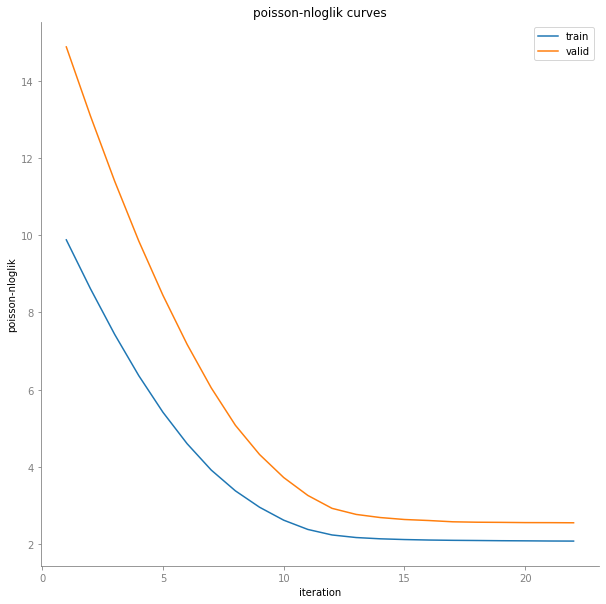

In [160]:
params_default = {
        'eta': 0.5,
        'max_depth': 5,
        'subsample': 0.9,
        'colsample_bytree': 0.7,

        'objective': 'count:poisson', 

        'booster': 'gbtree',
        'tree_method': 'hist',
        # 'max_bin': 30
    }

train_mask = (dataset_w_feats.index < VALID_SPLIT_DATE)
valid_mask = (dataset_w_feats.index >= VALID_SPLIT_DATE) & (dataset_w_feats.index < TEST_SPLIT_DATE)
test_mask = (dataset_w_feats.index >= TEST_SPLIT_DATE) & (dataset_w_feats.index <= END_DATE)

    
evals_result = {}
booster = xgboost.train(
    params=params_default,
    dtrain=xgboost.DMatrix(dataset_w_feats[train_mask][PREDICTORS], dataset_w_feats[train_mask][TARGET]),
    evals=((xgboost.DMatrix(dataset_w_feats[train_mask][PREDICTORS], dataset_w_feats[train_mask][TARGET]), 'train'),
           (xgboost.DMatrix(dataset_w_feats[valid_mask][PREDICTORS], dataset_w_feats[valid_mask][TARGET]), 'valid')),
    evals_result=evals_result,
    num_boost_round=22,
    #early_stopping_rounds = 15,
    verbose_eval = True)

fig, ax = plt.subplots(1, 1, figsize = (10, 10), facecolor='white')
plot_learning_curves(evals_result, 'poisson-nloglik', ax)
plt.show()

### Confirmation of error by visualising WMAPE scores

In [161]:
res = pd.DataFrame(columns = ['iters', 'wmape_train', 'wmape_valid'])
for i in [int(x) for x in np.linspace(0, booster.num_boosted_rounds(), 50).tolist()]:
    dataset_w_feats['prediction'] = booster.predict(xgboost.DMatrix(dataset_w_feats[PREDICTORS]), iteration_range=(0, i))
    wmape_train = wmape(dataset_w_feats[train_mask]['sales_qty'], dataset_w_feats[train_mask]['prediction'])
    wmape_valid = wmape(dataset_w_feats[valid_mask]['sales_qty'], dataset_w_feats[valid_mask]['prediction'])
    res = res.append(pd.DataFrame([[i, wmape_train, wmape_valid]], columns = ['iters', 'wmape_train', 'wmape_valid']))

In [159]:
res[res.wmape_valid == res.wmape_valid.min()]

iters  wmape_train  wmape_valid
0    22        44.42        45.23

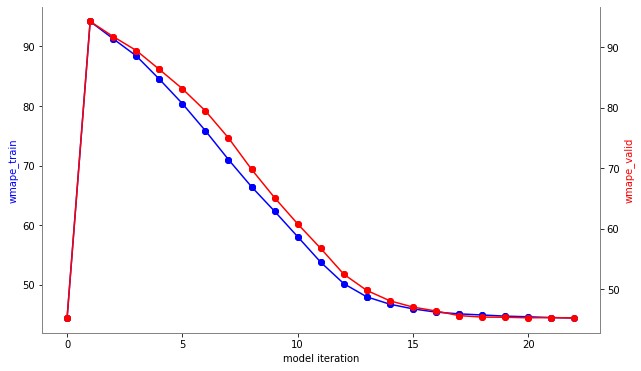

In [162]:
plt.figure(figsize=(10,6))
plt.plot(res['iters'].iloc[1:], res['wmape_train'].iloc[1:], marker='o', color='blue')
plt.ylabel('wmape_train', color='blue')
plt.xlabel('model iteration')

ax = plt.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')

ax2 = ax.twinx()

ax2.plot(res['iters'].iloc[1:], res['wmape_valid'].iloc[1:], color='red', marker='o')
ax2.set_ylabel('wmape_valid', color='red')

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_color('gray')
ax2.spines['left'].set_color('gray')
ax2.spines['bottom'].set_color('gray')

plt.show()

In [163]:
dataset_w_feats.loc[:, 'prediction'] = booster.predict(xgboost.DMatrix(dataset_w_feats[PREDICTORS]), iteration_range = (0, booster.best_iteration))

## Feature importances

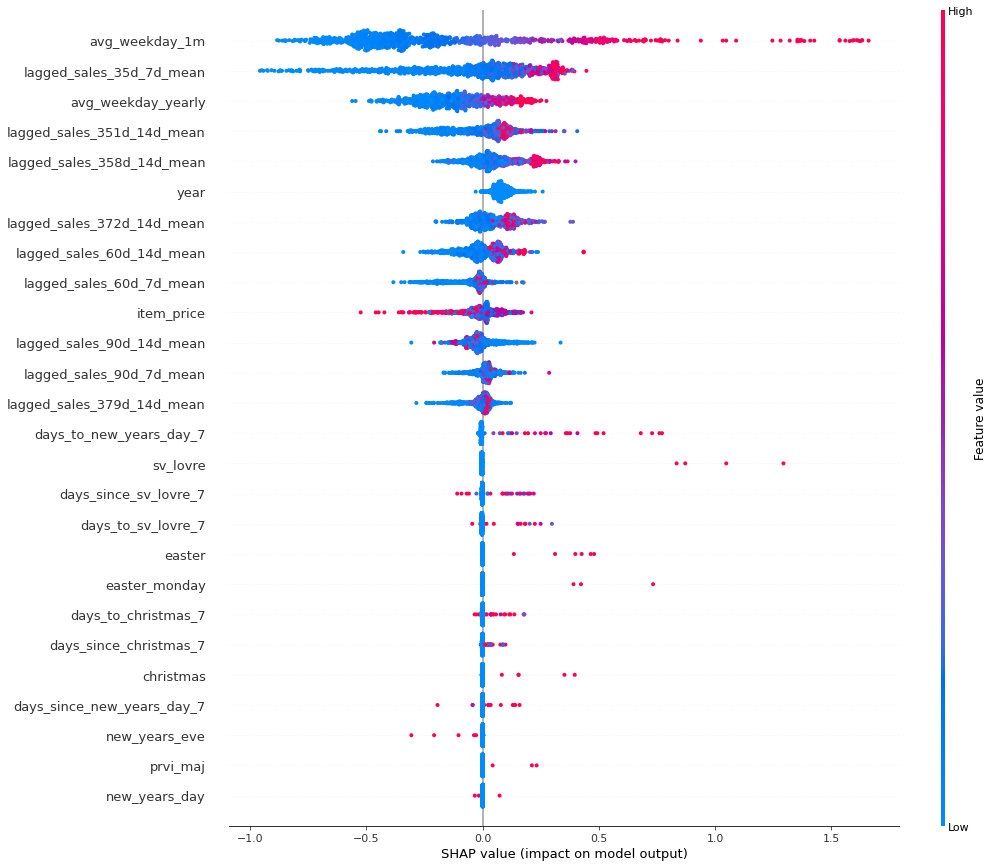

In [155]:
subsample_size = 1000

explainer = shap.TreeExplainer(booster)
predictors = booster.feature_names

df_sample = dataset_w_feats[valid_mask][predictors].sample(subsample_size)

shap_values = explainer(df_sample)

shap.summary_plot(shap_values.values, df_sample, max_display=60, show=True, plot_size=[15,15])
plt.show()

## Errors analysis

In [164]:
## Summary of results
dataset_w_feats.loc[:, 'error_diff'] = dataset_w_feats['prediction'] - dataset_w_feats['sales_qty']
dataset_w_feats.loc[:, 'abs_diff'] = np.abs(dataset_w_feats['prediction'] - dataset_w_feats['sales_qty'])

#wmape_train = dataset_w_feats[train_mask]['abs_diff'].sum()/dataset_w_feats[train_mask]['sales_qty'].sum()
#wmape_test = dataset_w_feats[test_mask]['abs_diff'].sum()/dataset_w_feats[test_mask]['sales_qty'].sum()
wmape_train = wmape(dataset_w_feats[train_mask]['sales_qty'], dataset_w_feats[train_mask]['prediction'])
wmape_test = wmape(dataset_w_feats[test_mask]['sales_qty'], dataset_w_feats[test_mask]['prediction'])

bias_train = wbias(dataset_w_feats[train_mask]['sales_qty'], dataset_w_feats[train_mask]['prediction'])
bias_test = wbias(dataset_w_feats[test_mask]['sales_qty'], dataset_w_feats[test_mask]['prediction'])

print("Train WMAPE:", wmape_train)
print("Test WMAPE:", wmape_test)
print("Train bias:", bias_train)
print("Test bias:", bias_test)

# Train WMAPE: 44.89
# Test WMAPE: 43.96
# Train bias: -0.74
# Test bias: -5.26

### Without holidays indicators
# Train WMAPE: 45.89
# Test WMAPE: 45.91
# Train bias: -0.16
# Test bias: -4.0

### With holidays indicators
# Train WMAPE: 45.87
# Test WMAPE: 45.53
# Train bias: -1.07
# Test bias: -2.33

### With st. lovre
# Train WMAPE: 45.39
# Test WMAPE: 45.62
# Train bias: -0.05
# Test bias: -3.11

###
# Train WMAPE: 44.7
# Test WMAPE: 45.03
# Train bias: -0.14
# Test bias: -4.48

# Train WMAPE: 44.33
# Test WMAPE: 44.78
# Train bias: -0.03
# Test bias: -3.39

# Train WMAPE: 45.35
# Test WMAPE: 43.98
# Train bias: -0.55
# Test bias: -2.1

Train WMAPE: 44.48
Test WMAPE: 45.91
Train bias: -1.04
Test bias: -3.36


In [116]:
dataset_w_feats[(dataset_w_feats.index.month == 5) & (dataset_w_feats.index.day == 1)].sales_qty#.describe()

sales_date
2017-05-01 00:00:00+00:00     5
2018-05-01 00:00:00+00:00     7
2019-05-01 00:00:00+00:00     6
2020-05-01 00:00:00+00:00     0
2013-05-01 00:00:00+00:00     8
                             ..
2020-05-01 00:00:00+00:00     0
2013-05-01 00:00:00+00:00    12
2014-05-01 00:00:00+00:00     0
2015-05-01 00:00:00+00:00     0
2016-05-01 00:00:00+00:00     0
Name: sales_qty, Length: 270, dtype: int64

In [117]:
dataset_w_feats[(dataset_w_feats.index.month == 4) & (dataset_w_feats.index.day.isin([25, 26, 27, 28, 29]))].sales_qty.describe()

count    1350.000000
mean        4.612593
std        10.894480
min         0.000000
25%         0.000000
50%         1.000000
75%         5.000000
max       169.000000
Name: sales_qty, dtype: float64

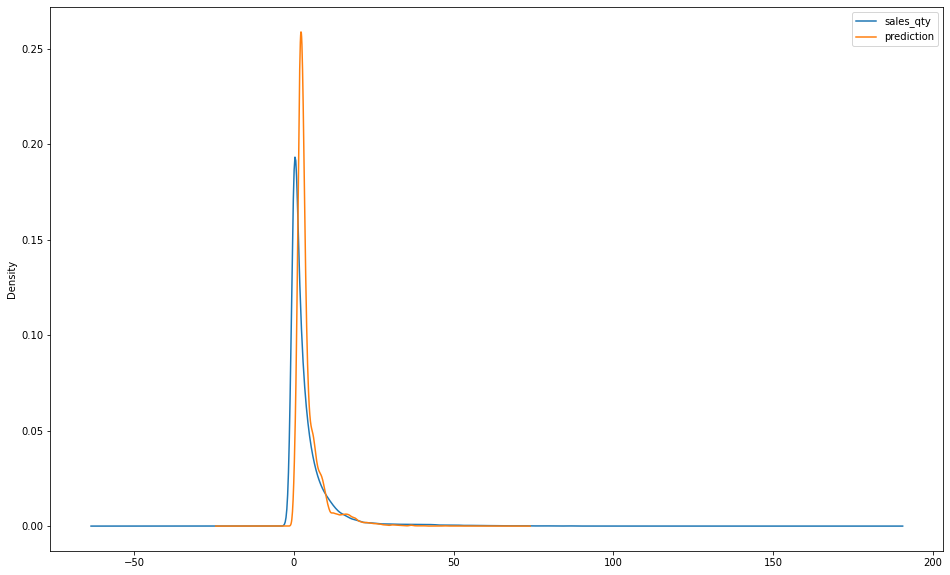

<AxesSubplot:ylabel='Density'>

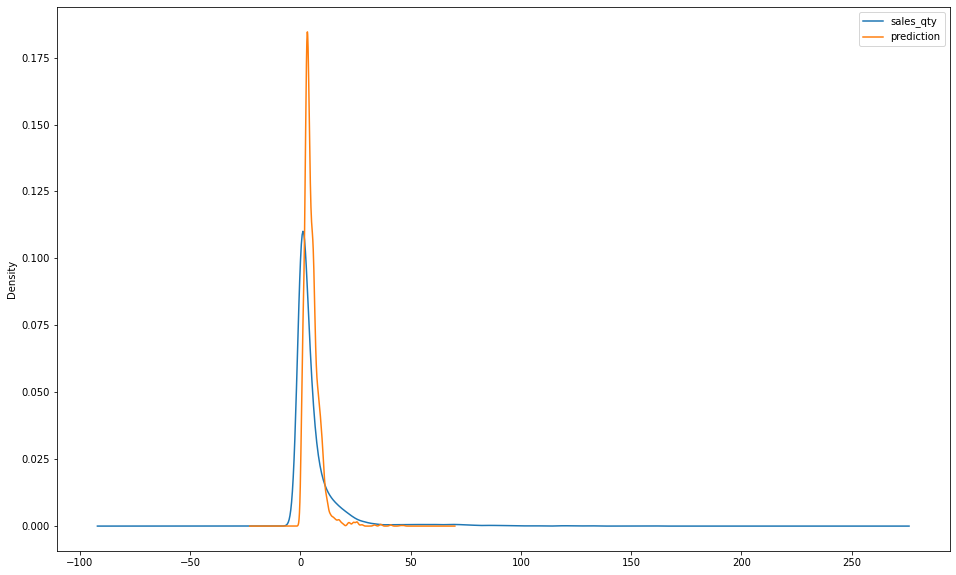

In [118]:
# ## Training set targets
# y_train[y_train>0].plot(kind='hist', bins=100, figsize=(12, 6))
dataset_w_feats[train_mask].plot(y=['sales_qty', 'prediction'], kind='kde', figsize=(16,10))
plt.show()
# ## Test set targets
dataset_w_feats[test_mask].plot(y=['sales_qty', 'prediction'], kind='kde', figsize=(16,10))

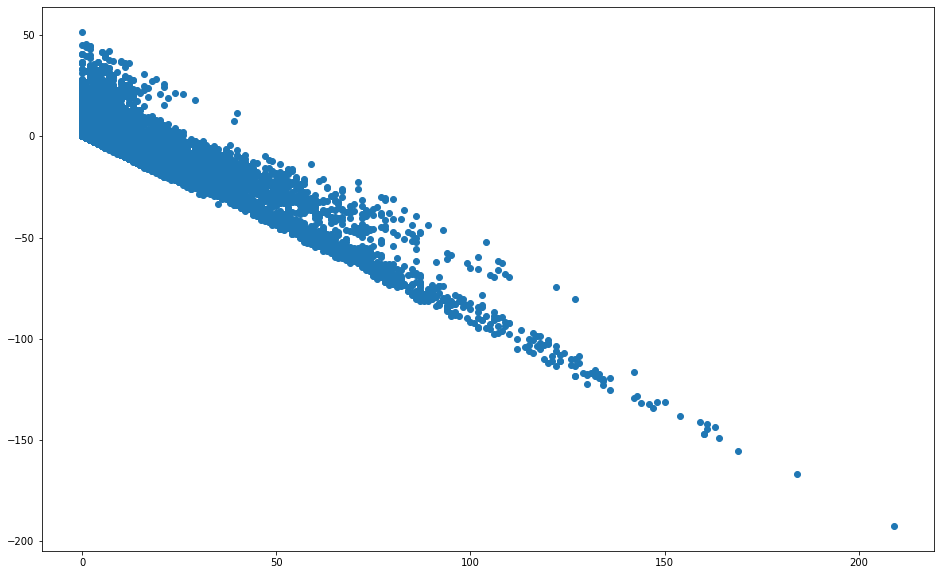

In [119]:
plt.figure(figsize=(16,10))
plt.scatter(dataset_w_feats.sales_qty, dataset_w_feats.error_diff)

In [120]:
dataset_w_feats.groupby('item_name')['sales_qty'].sum().sort_values(ascending=False).index[:20]

Index(['Kava s mlijekom velika', 'Kava', 'Cedevita', 'Nescaffe',
       'Kava s mlijekom', 'Coca Cola', 'Caj', 'Budweiser', 'Jamnica sensation',
       'Mineralna voda', 'Kava sa slagom velika', 'Emotion',
       'Caj s limunom i medom', 'Niksicko pivo', 'Pipi', 'Bijela kava',
       'Orahovac', 'Spezi+kava', 'Ozujsko pivo', 'Beck`s'],
      dtype='object', name='item_name')

## Visualize scores

In [166]:

wmape_train_valid_scores = dataset_w_feats[train_mask | valid_mask].groupby('item_name').apply(lambda x: pd.Series({'bias': wbias(x['sales_qty'], x['prediction']), 
                                                                'wmape': wmape(x['sales_qty'], x['prediction']),
                                                               'total_sales': x['sales_qty'].sum(),
                                                               'total_prediction': x['prediction'].sum()})
                                                                ).sort_values(by='total_sales', ascending=False).reset_index()
wmape_test_scores = dataset_w_feats[test_mask].groupby('item_name').apply(lambda x: pd.Series({'bias': wbias(x['sales_qty'], x['prediction']), 
                                                                'wmape': wmape(x['sales_qty'], x['prediction']),
                                                                'total_sales': x['sales_qty'].sum(),
                                                                'total_prediction': x['prediction'].sum()})
                                                                ).sort_values(by='total_sales', ascending=False).reset_index()

(0.0, 220.169)

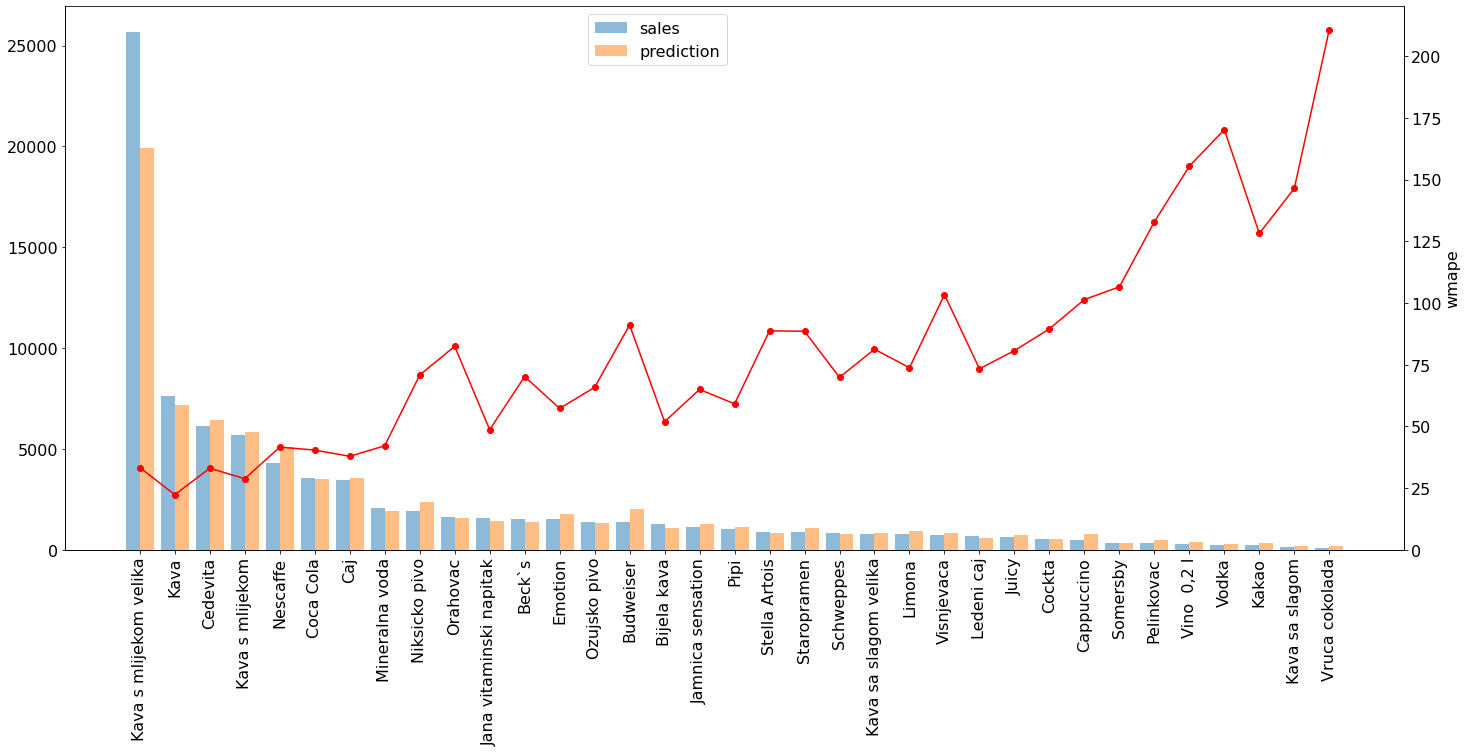

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(24,10))

X_axis = np.arange(len(wmape_test_scores['item_name']))
p1 = ax.bar(X_axis - 0.2, wmape_test_scores['total_sales'], width=0.4, alpha=0.5, label='sales')
p2 = ax.bar(X_axis + 0.2, wmape_test_scores['total_prediction'], width=0.4, alpha=0.5, label='prediction')
ax.spines['top'].set_visible(False)
ax.set_xticks(X_axis)
ax.set_xticklabels(wmape_test_scores['item_name'], rotation=90, fontsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.legend(bbox_to_anchor=(0.5, 1), fontsize=16)

ax2 = ax.twinx()
p3 = ax2.plot(X_axis, wmape_test_scores['wmape'], color = 'red', marker='o', label='wmape')
ax2.set_ylabel('wmape', fontsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax2.set_ylim([0, ax2.get_ylim()[1]])


<AxesSubplot:xlabel='sales_date'>

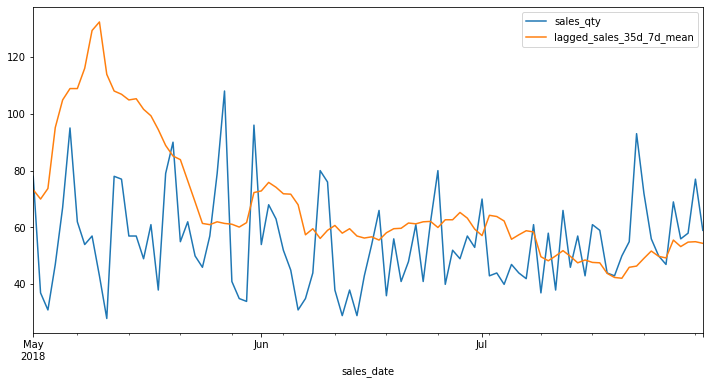

In [168]:
dataset_w_feats[(dataset_w_feats.index.year == 2018) &
                (dataset_w_feats.index.month.isin([5,6,7])) &
                (dataset_w_feats['item_name'] == 'Kava s mlijekom velika')].plot(y=['sales_qty', 'lagged_sales_35d_7d_mean'], figsize=(12, 6))

In [169]:
from statsmodels.graphics.tsaplots import plot_acf


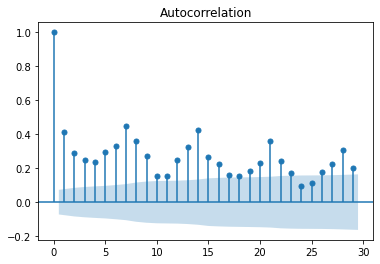

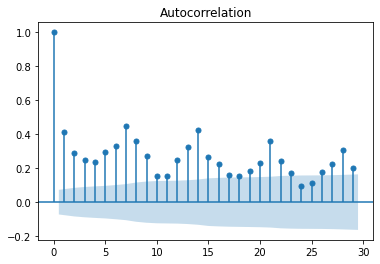

In [170]:
plot_acf(dataset_w_feats[(dataset_w_feats.index.year.isin([2017, 2018])) & 
                (dataset_w_feats['item_name'] == 'Cedevita')]['sales_qty'])

<AxesSubplot:xlabel='sales_date'>

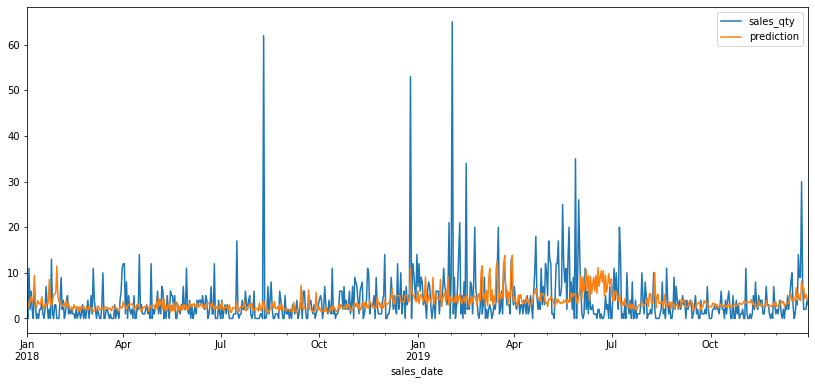

In [171]:
dataset_w_feats[(test_mask | valid_mask) & (dataset_w_feats.item_name == 'Orahovac')].plot(y=['sales_qty', 'prediction'], figsize=(14, 6))

In [127]:
# check trend in error

<AxesSubplot:xlabel='day_of_week'>

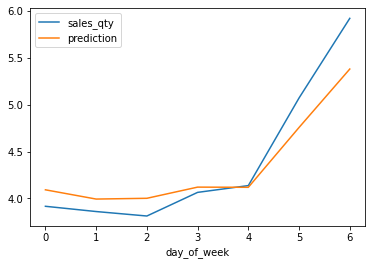

In [172]:
dataset_w_feats[train_mask].groupby('day_of_week')[['sales_qty', 'prediction']].mean().reset_index().plot(x='day_of_week', y=['sales_qty', 'prediction'])

<AxesSubplot:xlabel='day_of_week'>

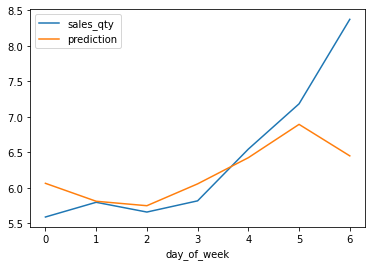

In [173]:
dataset_w_feats[test_mask].groupby('day_of_week')[['sales_qty', 'prediction']].mean().reset_index().plot(x='day_of_week', y=['sales_qty', 'prediction'])

#### Item: Kava s mlijekom velika ####
## Train & valid scores: 
WMAPE: 64.59
Bias: -64.53
## Test scores: 
WMAPE: 83.43
Bias: -83.43


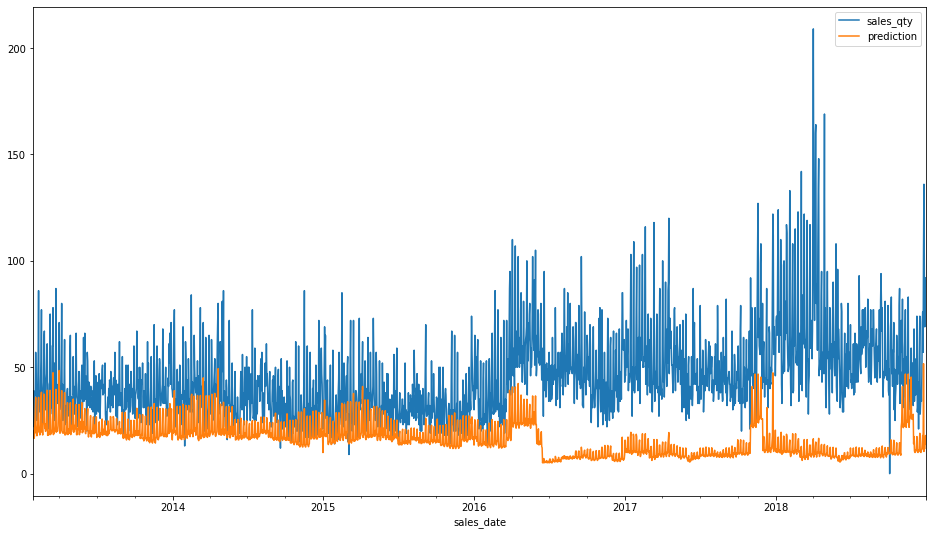

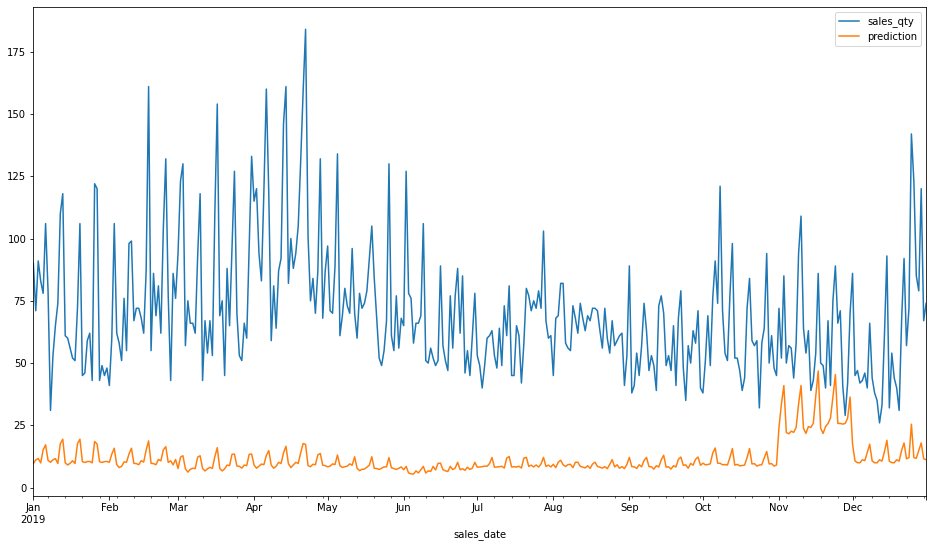

#### Item: Kava ####
## Train & valid scores: 
WMAPE: 32.74
Bias: -19.12
## Test scores: 
WMAPE: 49.79
Bias: -47.13


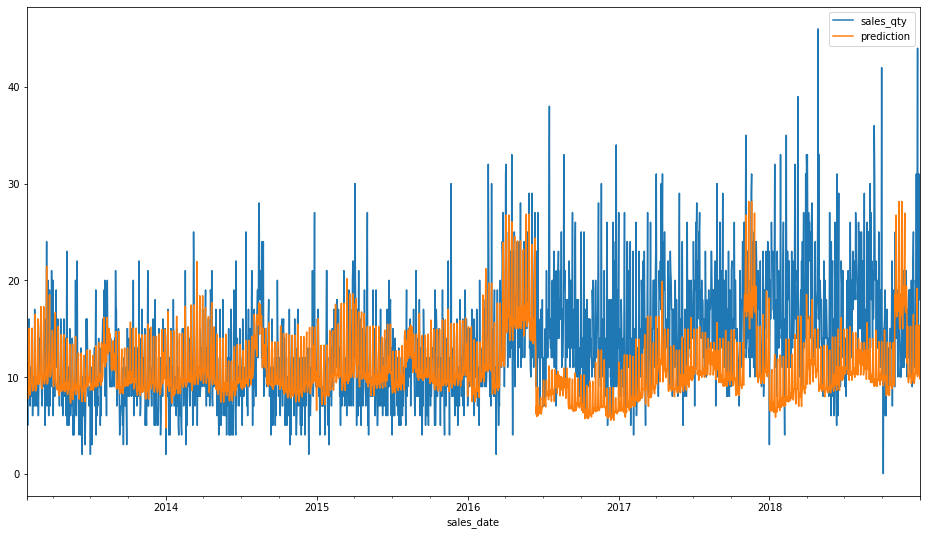

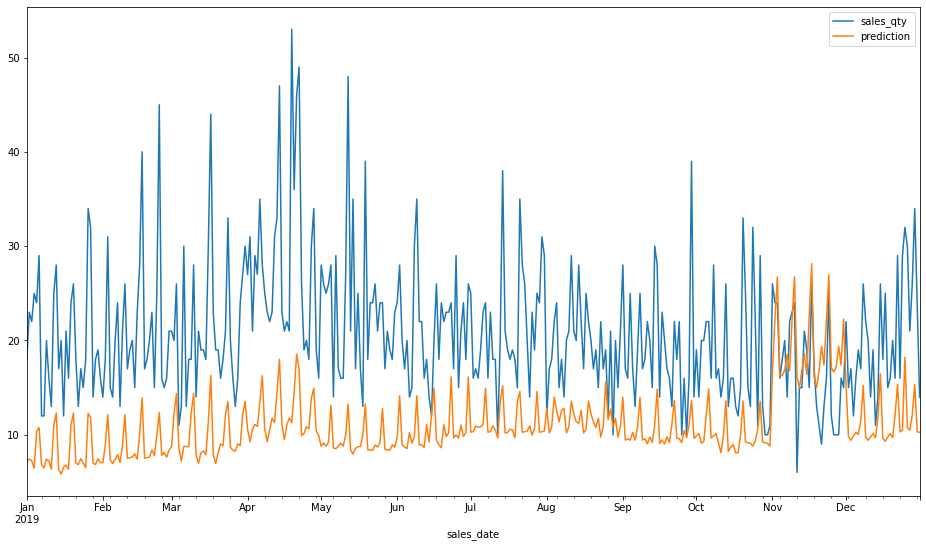

#### Item: Cedevita ####
## Train & valid scores: 
WMAPE: 57.51
Bias: -47.38
## Test scores: 
WMAPE: 64.78
Bias: -63.54


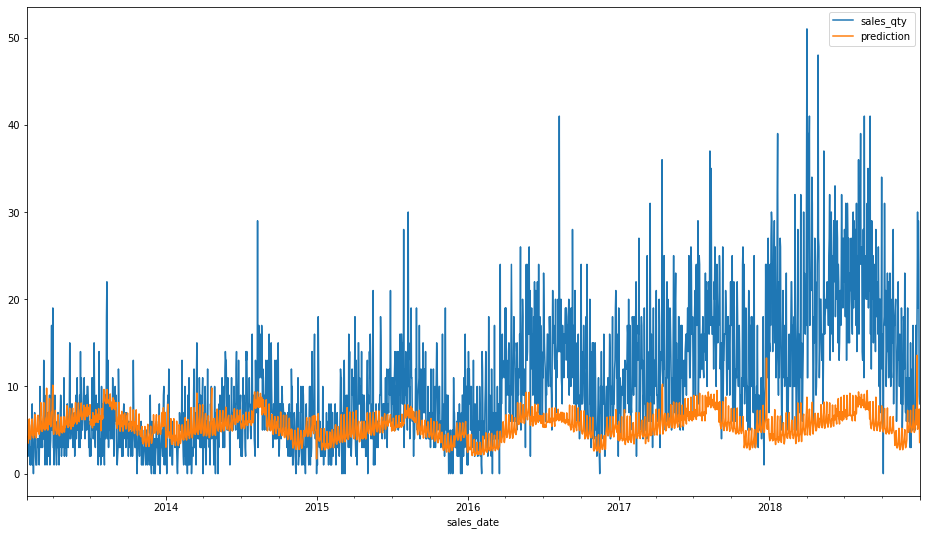

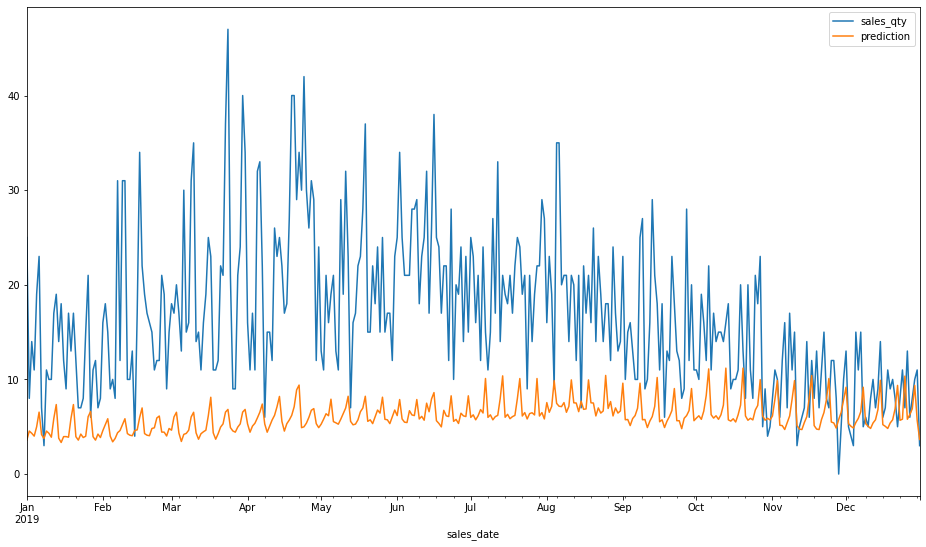

#### Item: Nescaffe ####
## Train & valid scores: 
WMAPE: 62.04
Bias: -60.51
## Test scores: 
WMAPE: 66.51
Bias: -65.59


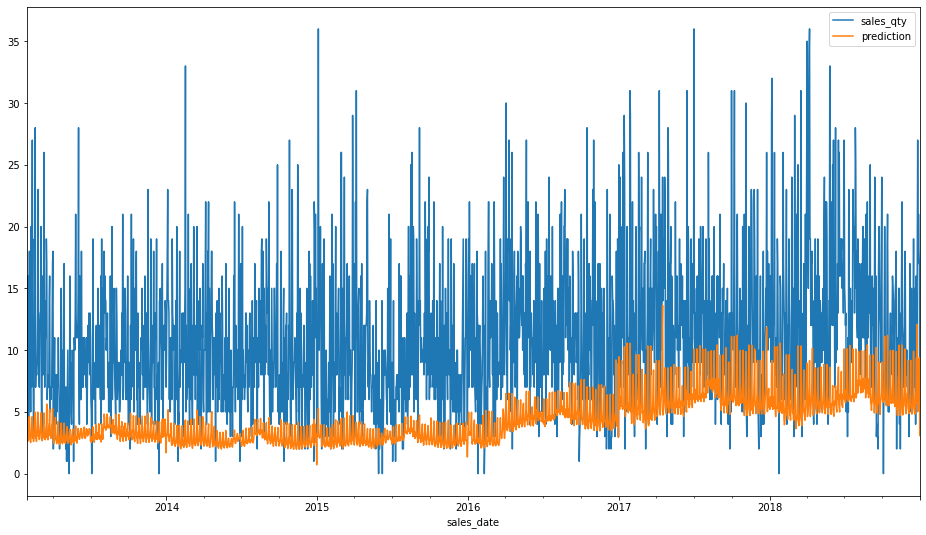

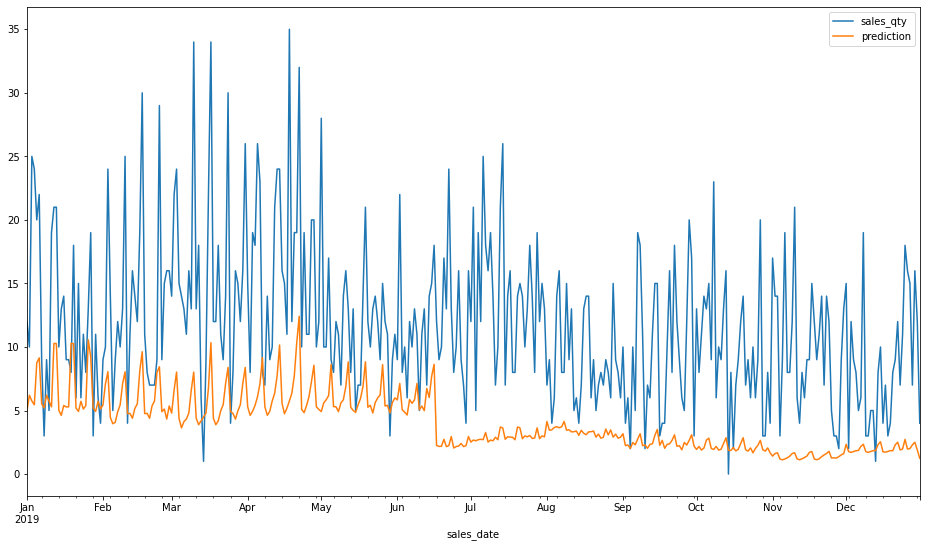

#### Item: Kava s mlijekom ####
## Train & valid scores: 
WMAPE: 53.38
Bias: -46.85
## Test scores: 
WMAPE: 55.16
Bias: -54.05


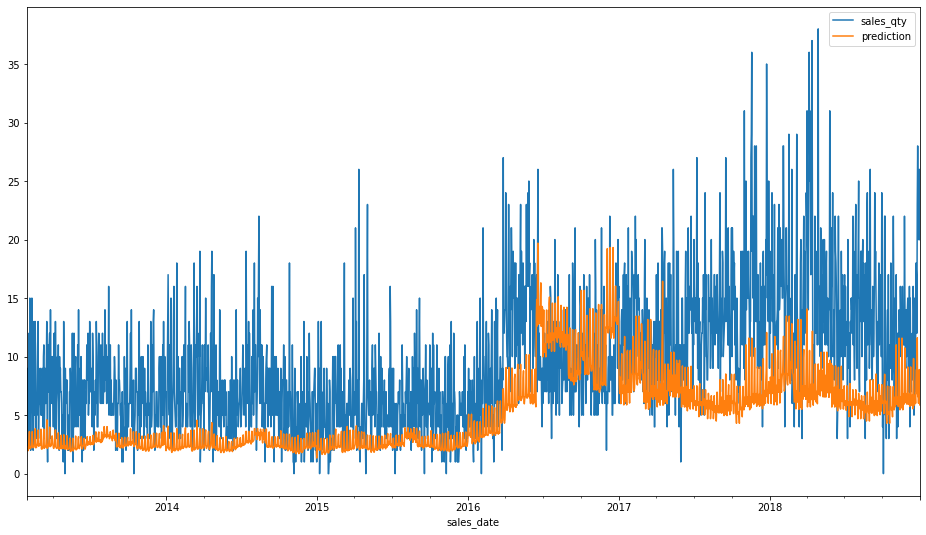

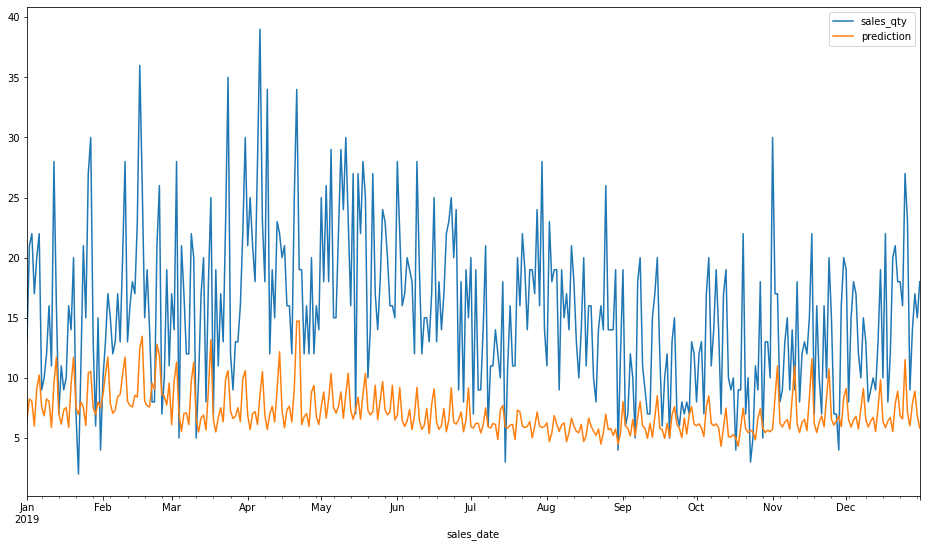

#### Item: Coca Cola ####
## Train & valid scores: 
WMAPE: 56.12
Bias: -40.92
## Test scores: 
WMAPE: 64.83
Bias: -63.41


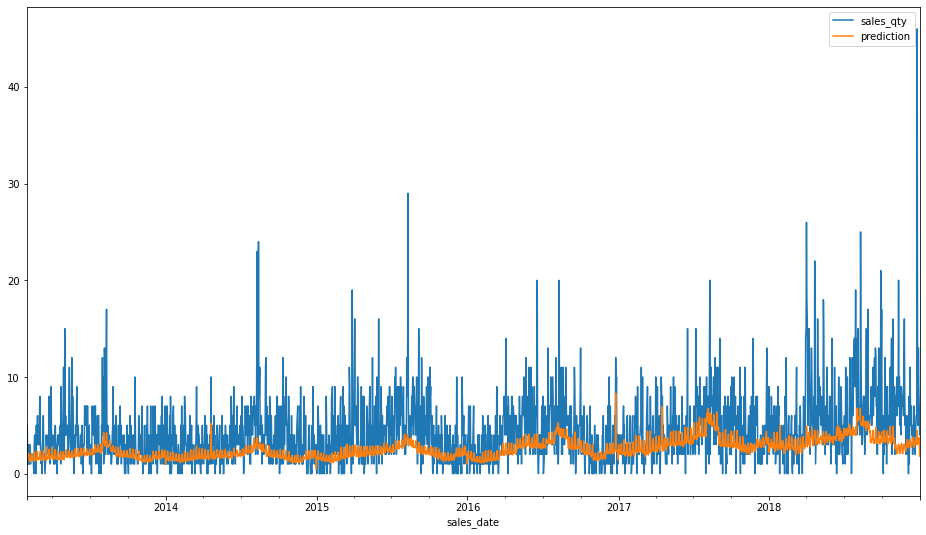

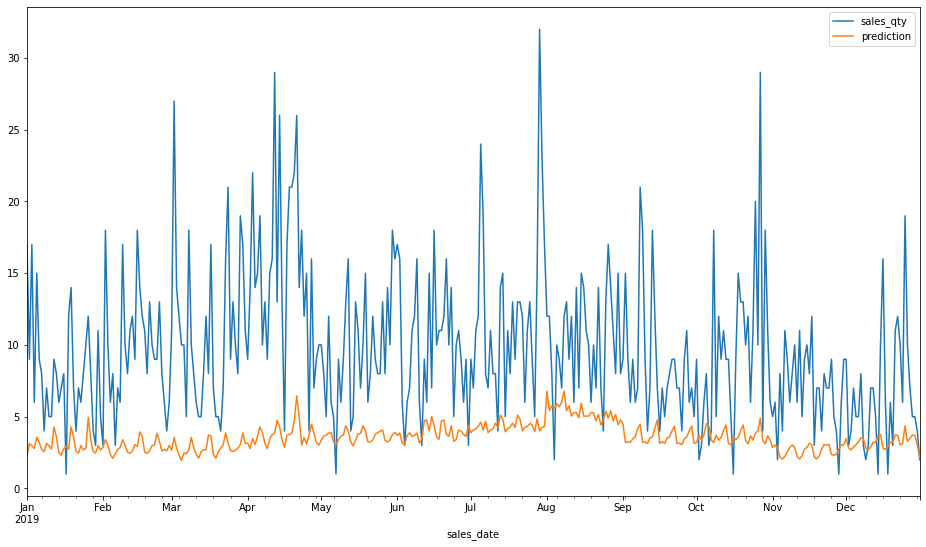

#### Item: Caj ####
## Train & valid scores: 
WMAPE: 107.72
Bias: 54.26
## Test scores: 
WMAPE: 77.04
Bias: 23.34


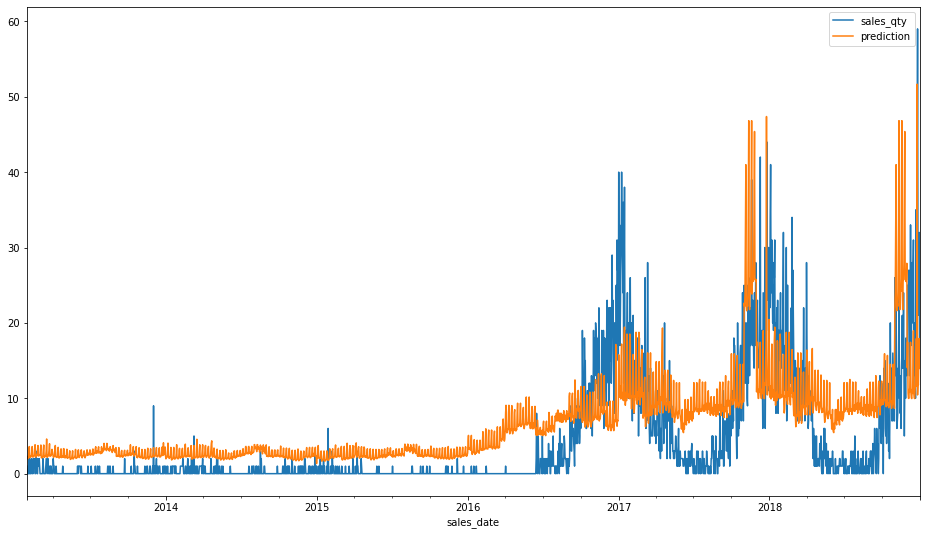

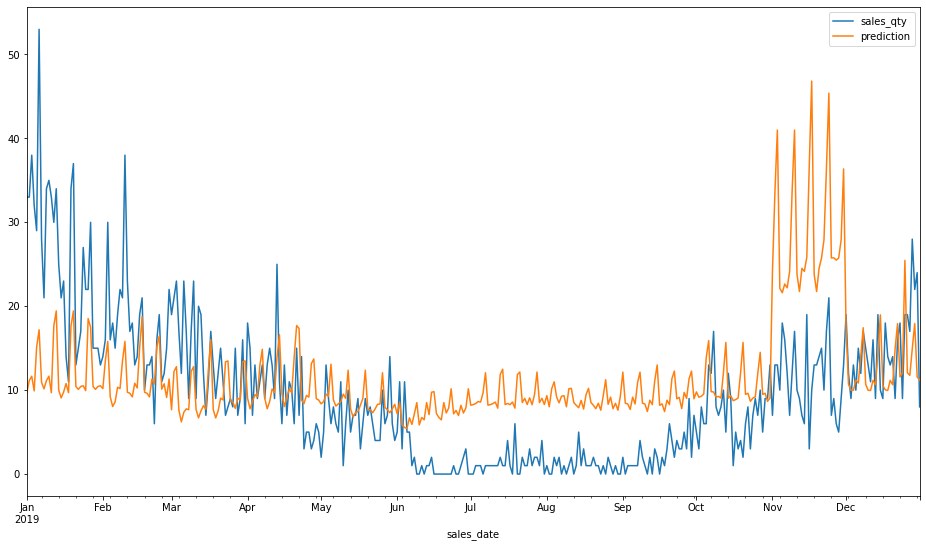

#### Item: Budweiser ####
## Train & valid scores: 
WMAPE: 67.4
Bias: -52.76
## Test scores: 
WMAPE: 83.13
Bias: -33.65


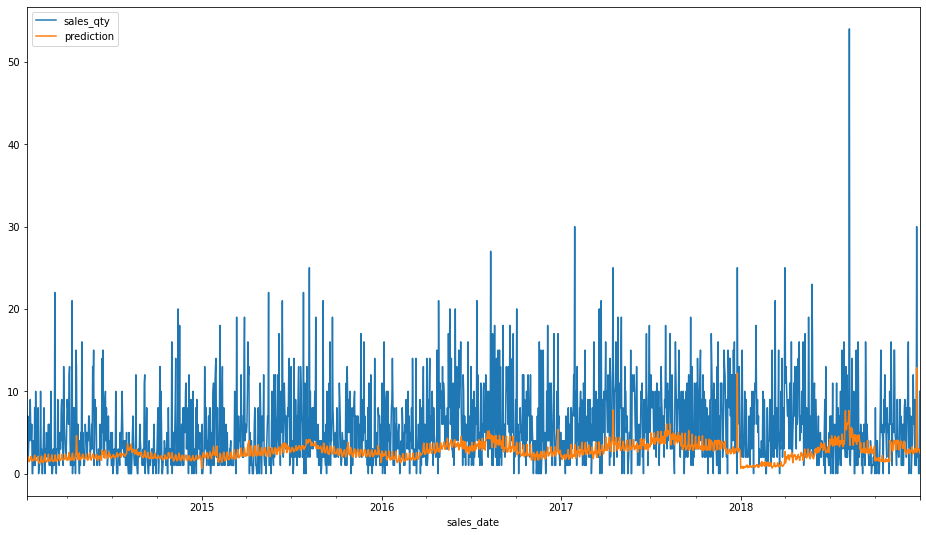

KeyboardInterrupt: 

In [130]:
for item in dataset_w_feats.groupby('item_name')['sales_qty'].sum().sort_values(ascending=False).index[:20]:
    print(f"#### Item: {item} ####")
    print("## Train & valid scores: ")
    print(f"WMAPE: {wmape_train_valid_scores.loc[(wmape_train_valid_scores.item_name == item), 'wmape'].values[0]}")
    print(f"Bias: {wmape_train_valid_scores.loc[(wmape_train_valid_scores.item_name == item), 'bias'].values[0]}")
    print("## Test scores: ")
    print(f"WMAPE: {wmape_test_scores.loc[(wmape_test_scores.item_name == item), 'wmape'].values[0]}")
    print(f"Bias: {wmape_test_scores.loc[(wmape_test_scores.item_name == item), 'bias'].values[0]}")
    dataset_w_feats[(train_mask | valid_mask) & (dataset_w_feats.item_name == item)].plot(y=['sales_qty', 'prediction'], figsize=(16,9))
    dataset_w_feats[(test_mask) & (dataset_w_feats.item_name == item)].plot(y=['sales_qty', 'prediction'], figsize=(16,9))
    plt.show()

# Experiment - hyperparameter tuning, stratification by bins of sales and target scaling

In [ ]:
!pip install hyperopt

In [55]:
TARGET = 'sales_qty_relative'

In [56]:
# dataset_w_feats.loc[:, 'lagged_sales_35d_365d_mean'] = dataset_w_feats.groupby(['item_name'])['sales_qty'].shift(28+7).rolling(365, min_periods=1).mean().fillna(method='bfill')
# # Capuccino had problems only with Nan and np.inf, we'll forgive ourselves a little target leakage for this item
# mask = (dataset_w_feats['sales_qty_relative'] == np.inf) | (dataset_w_feats['sales_qty_relative'].isnull())
# dataset_w_feats.loc[(dataset_w_feats.item_name == 'Cappuccino') & (mask), 'lagged_sales_35d_365d_mean'] = dataset_w_feats.loc[(dataset_w_feats.item_name == 'Cappuccino'), 'sales_qty'].mean()
# dataset_w_feats.loc[:, 'sales_qty_relative'] = dataset_w_feats['sales_qty']/dataset_w_feats['lagged_sales_35d_365d_mean']

#dataset_w_feats.loc[:, 'sales_qty_relative'] = dataset_w_feats['sales_qty_relative'].fillna(0)

In [57]:
#dataset_w_feats[(dataset_w_feats['sales_qty_relative'] == np.inf) | (dataset_w_feats['sales_qty_relative'].isnull())][100:160]#.item_name.unique()

In [58]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [61]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
       'eta': hp.uniform('eta', 0, 2),
        'gamma': hp.uniform('gamma', 1 ,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 40, 60, 1)
    }

In [63]:
dataset_w_feats.columns

Index(['item_name', 'sales_qty', 'item_price', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'month_of_year_1', 'month_of_year_2',
       'month_of_year_3', 'month_of_year_4', 'month_of_year_5',
       'month_of_year_6', 'month_of_year_7', 'month_of_year_8',
       'month_of_year_9', 'month_of_year_10', 'month_of_year_11', 'year',
       'first_third_of_month', 'second_third_of_month', 'last_third_of_month',
       'closed', 'easter', 'easter_monday', 'christmas', 'new_years_day',
       'new_years_eve', 'lagged_sales_358d_14d_mean',
       'lagged_sales_372d_14d_mean', 'lagged_sales_35d_7d_mean',
       'lagged_sales_60d_7d_mean', 'month', 'day_of_week', 'avg_weekday_1m',
       'sv_lovre', 'prvi_maj', 'dates', 'days_to_sv_lovre_7',
       'days_since_sv_lovre_7', 'days_to_new_years_day_7',
       'days_since_new_years_day_7', 'prediction', 'error_diff', 'abs_diff'],
      dtype='object')

In [ ]:
space['max_depth']

In [ ]:
PREDICTORS = ['item_price',
 'lagged_sales_365d_14d_mean',
 'lagged_sales_35d_7d_mean',
 'year',
 'avg_weekday_1m',
 'easter',
 'easter_monday',
 'christmas',
 'new_years_day',
 'new_years_eve']

In [ ]:
def hyperparameter_tuning(space):
    params_default = {
        'eta': 0.5,
        'gamma': space['gamma'],
        'max_depth': int(space['max_depth']),
        'subsample': 0.9,
        'colsample_bytree': space['colsample_bytree'],
        'num_boost_round': space['n_estimators'],
        'objective': 'count:poisson', 

        'booster': 'gbtree',
        'tree_method': 'hist',
        # 'max_bin': 30
    }
    booster = xgboost.train(
        params=params_default,
        dtrain=xgboost.DMatrix(dataset_w_feats[train_mask][PREDICTORS], dataset_w_feats[train_mask][TARGET]),
        evals=((xgboost.DMatrix(dataset_w_feats[train_mask][PREDICTORS], dataset_w_feats[train_mask][TARGET]), 'train'),
               (xgboost.DMatrix(dataset_w_feats[valid_mask][PREDICTORS], dataset_w_feats[valid_mask][TARGET]), 'valid')),
        evals_result=evals_result,
        num_boost_round=200,
        early_stopping_rounds = 15,
        verbose_eval = False)
    
    valid_poisson_nloglik = evals_result['valid']['poisson-nloglik'][booster.best_iteration]
    dataset_w_feats.loc[:, 'prediction'] = booster.predict(xgboost.DMatrix(dataset_w_feats[PREDICTORS]), iteration_range = (0, booster.best_iteration))
    dataset_w_feats.loc[:, 'error_diff'] = dataset_w_feats['prediction'] - dataset_w_feats['sales_qty']
    dataset_w_feats.loc[:, 'abs_diff'] = np.abs(dataset_w_feats['prediction'] - dataset_w_feats['sales_qty'])
    wmape_valid = wmape(dataset_w_feats[valid_mask]['sales_qty'], dataset_w_feats[valid_mask]['prediction'])

    print ("SCORE:", wmape_valid)
    #change the metric if you like
    return {'loss':wmape_valid, 'status': STATUS_OK, 'model': booster}

In [ ]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print (best)

In [ ]:
params_default = {
        'eta': 0.5,
        'max_depth': 3,
        'subsample': 0.9,
        'colsample_bytree': 0.75,
        'gamma': 6.16,
        'min_child_weight': 2,
        'objective': 'count:poisson', 

        'booster': 'gbtree',
        'tree_method': 'hist',
        # 'max_bin': 30
    }

train_mask = (dataset_w_feats.index < VALID_SPLIT_DATE)
valid_mask = (dataset_w_feats.index >= VALID_SPLIT_DATE) & (dataset_w_feats.index < TEST_SPLIT_DATE)
test_mask = (dataset_w_feats.index >= TEST_SPLIT_DATE) & (dataset_w_feats.index <= END_DATE)

    
evals_result = {}
booster = xgboost.train(
    params=params_default,
    dtrain=xgboost.DMatrix(dataset_w_feats[train_mask][PREDICTORS], dataset_w_feats[train_mask][TARGET]),
    evals=((xgboost.DMatrix(dataset_w_feats[train_mask][PREDICTORS], dataset_w_feats[train_mask][TARGET]), 'train'),
           (xgboost.DMatrix(dataset_w_feats[valid_mask][PREDICTORS], dataset_w_feats[valid_mask][TARGET]), 'valid')),
    evals_result=evals_result,
    num_boost_round=200,
    early_stopping_rounds = 15,
    verbose_eval = True)

fig, ax = plt.subplots(1, 1, figsize = (10, 10), facecolor='white')
plot_learning_curves(evals_result, 'poisson-nloglik', ax)
plt.show()

In [ ]:
dataset_w_feats.loc[:, 'prediction'] = booster.predict(xgboost.DMatrix(dataset_w_feats[PREDICTORS]), iteration_range = (0, booster.best_iteration))

## Errors analysis

In [ ]:
## Summary of results
dataset_w_feats.loc[:, 'error_diff'] = dataset_w_feats['prediction'] - dataset_w_feats['sales_qty']
dataset_w_feats.loc[:, 'abs_diff'] = np.abs(dataset_w_feats['prediction'] - dataset_w_feats['sales_qty'])

#wmape_train = dataset_w_feats[train_mask]['abs_diff'].sum()/dataset_w_feats[train_mask]['sales_qty'].sum()
#wmape_test = dataset_w_feats[test_mask]['abs_diff'].sum()/dataset_w_feats[test_mask]['sales_qty'].sum()
wmape_train = wmape(dataset_w_feats[train_mask]['sales_qty'], dataset_w_feats[train_mask]['prediction'])
wmape_test = wmape(dataset_w_feats[test_mask]['sales_qty'], dataset_w_feats[test_mask]['prediction'])

bias_train = wbias(dataset_w_feats[train_mask]['sales_qty'], dataset_w_feats[train_mask]['prediction'])
bias_test = wbias(dataset_w_feats[test_mask]['sales_qty'], dataset_w_feats[test_mask]['prediction'])

print("Train WMAPE:", wmape_train)
print("Test WMAPE:", wmape_test)
print("Train bias:", bias_train)
print("Test bias:", bias_test)

# Train WMAPE: 44.89
# Test WMAPE: 43.96
# Train bias: -0.74
# Test bias: -5.26

### Without holidays indicators
# Train WMAPE: 45.89
# Test WMAPE: 45.91
# Train bias: -0.16
# Test bias: -4.0

### With holidays indicators
# Train WMAPE: 45.87
# Test WMAPE: 45.53
# Train bias: -1.07
# Test bias: -2.33

### With st. lovre
# Train WMAPE: 45.39
# Test WMAPE: 45.62
# Train bias: -0.05
# Test bias: -3.11

### With hyperparameter tuning
# Train WMAPE: 47.06
# Test WMAPE: 44.02
# Train bias: -0.07
# Test bias: -2.34
